# Апробация моделей частотных сканов на данных из набора "1564ЛЕ1 при разных U1 Ur август 2022"

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

## 0. Импорт модулей

In [2]:
from joblib import dump, load
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from pydlts.fsmodels import SklMultiExpFrequencyScan, SklSingleExpFrequencyScan

from pydlts.fsplots import plot_experimental_points
from pydlts.fsplots import plot_spectr
from pydlts.fsplots import plot_model
from pydlts.fsplots import plot_loss_path
from pydlts.fsplots import plot_deviations

%matplotlib inline

## 1. Чтение данных

In [3]:
DATASETS_PATH = '../datasets/'
PLOTS_PATH = '../plots/'
MODELS_PATH = '../models/'

In [4]:
file_names = listdir(DATASETS_PATH)

### 1.1. Выберем данные полученные при $U_1 = -4$ В и $U_R = -5$ В
Данному критерию соответствуют 3 частотных скана

In [5]:
u1 = -4
ur = -5

data_frames = [[file_name, pd.read_csv(DATASETS_PATH + file_name, parse_dates=[0])] for file_name in file_names]

condition = lambda frame: frame.loc[0, 'u1']==u1 and frame.loc[0, 'ur']==ur
data_frames = [[name, frame] for [name, frame] in data_frames if condition(frame)]

In [6]:
len(data_frames)

3

Отсортируем частотные сканы по температуре в начале сканирования

In [7]:
key_func = lambda x: x[1].temperature_k.iloc[0]
data_frames.sort(key=key_func)

for i, item in enumerate(data_frames):
    print(f'{i}.', item[0])

0. 1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01.csv
1. 1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01.csv
2. 1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1.csv


Ниже приведён фрагмент таблицы с данными для частотного скана при температуре $T = -10^\circ C$

In [8]:
print(data_frames[0][0])
data_frames[0][1].head()

1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01.csv


,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2022-08-02 17:55:01,2500.0000,5.276,262.940,0.000528,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
1,2022-08-02 17:55:05,2443.0925,5.449,262.941,0.000545,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
2,2022-08-02 17:55:09,2387.4812,5.855,262.941,0.000585,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
3,2022-08-02 17:55:13,2333.1355,6.665,262.940,0.000666,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
4,2022-08-02 17:55:17,2280.0269,6.626,262.936,0.000663,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1


Частотный скан содержит 340 точек. Данные не содержат пропусков.

In [9]:
data_frames[0][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               340 non-null    datetime64[ns]
 1   frequency_hz       340 non-null    float64       
 2   dlts_v             340 non-null    float64       
 3   temperature_k      340 non-null    float64       
 4   dlts_pf            340 non-null    float64       
 5   bs                 340 non-null    int64         
 6   ls                 340 non-null    int64         
 7   f_pulse            340 non-null    float64       
 8   u1                 340 non-null    float64       
 9   ur                 340 non-null    float64       
 10  time_between_meas  340 non-null    float64       
 11  integral_time      340 non-null    float64       
 12  specimen_name      340 non-null    object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usag

Ниже приведён фрагмент таблицы с данными для частотного скана при температуре $T = +10^\circ C$

In [10]:
print(data_frames[1][0])
data_frames[1][1].head()

1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01.csv


,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2022-08-04 15:21:09,2500.0000,3.122,283.194,0.001561,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
1,2022-08-04 15:21:13,2443.0925,3.187,283.187,0.001593,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
2,2022-08-04 15:21:17,2387.4812,3.201,283.191,0.001600,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
3,2022-08-04 15:21:21,2333.1355,3.259,283.206,0.001629,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
4,2022-08-04 15:21:25,2280.0269,3.271,283.199,0.001636,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1


Частотный скан содержит 340 точек. Данные не содержат пропусков.

In [11]:
data_frames[1][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               340 non-null    datetime64[ns]
 1   frequency_hz       340 non-null    float64       
 2   dlts_v             340 non-null    float64       
 3   temperature_k      340 non-null    float64       
 4   dlts_pf            340 non-null    float64       
 5   bs                 340 non-null    int64         
 6   ls                 340 non-null    int64         
 7   f_pulse            340 non-null    float64       
 8   u1                 340 non-null    float64       
 9   ur                 340 non-null    float64       
 10  time_between_meas  340 non-null    float64       
 11  integral_time      340 non-null    float64       
 12  specimen_name      340 non-null    object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usag

Ниже приведён фрагмент таблицы с данными для частотного скана при температуре $T = +30^\circ C$

In [12]:
print(data_frames[2][0])
data_frames[2][1].head()

1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1.csv


,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2022-08-03 14:34:48,2500.0000,1.456,303.264,0.007280,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
1,2022-08-03 14:34:52,1985.8207,1.526,303.276,0.007630,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
2,2022-08-03 14:34:56,1577.3937,1.649,303.279,0.008245,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
3,2022-08-03 14:35:00,1252.9686,1.755,303.281,0.008775,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
4,2022-08-03 14:35:03,995.2686,1.907,303.281,0.009535,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1


Частотный скан содержит 34 точки. Данные не содержат пропусков.

In [13]:
data_frames[2][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               34 non-null     datetime64[ns]
 1   frequency_hz       34 non-null     float64       
 2   dlts_v             34 non-null     float64       
 3   temperature_k      34 non-null     float64       
 4   dlts_pf            34 non-null     float64       
 5   bs                 34 non-null     int64         
 6   ls                 34 non-null     int64         
 7   f_pulse            34 non-null     float64       
 8   u1                 34 non-null     float64       
 9   ur                 34 non-null     float64       
 10  time_between_meas  34 non-null     float64       
 11  integral_time      34 non-null     float64       
 12  specimen_name      34 non-null     object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usage:

## 2. 1564ЛЕ1№1\_п1\_2500Гц-1Гц\_1пФ\_-10С\_-4В-5В\_10мВ\_10мкс\_шаг\_0,01.csv.csv
### 2.1. Подготовка экспериментальных данных

Чтение данных

In [14]:
print(data_frames[0][0])

1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01.csv


In [15]:
def get_X_y(dataset):
    filling_pulse = dataset.f_pulse[0] * 10 ** -6
    
    X = np.log10(dataset.frequency_hz.to_numpy())
    y = dataset.dlts_pf.to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
    
    return filling_pulse, X_train, y_train, X_test, y_test

In [16]:
filling_pulse, X_train, y_train, X_test, y_test = get_X_y(data_frames[0][1])

Выведем тренировачный набор данных

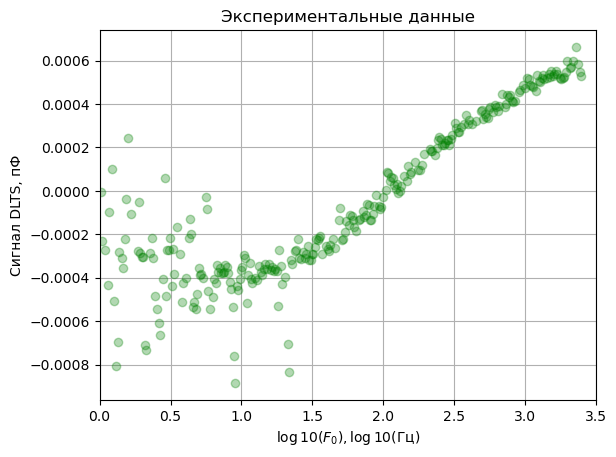

In [17]:
fig, ax = plot_experimental_points(X_train, y_train)
ax.set_xlim([0, 3.5])
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_train_data.pdf',
            bbox_inches='tight')
plt.show()

Выведем тестовый набор данных

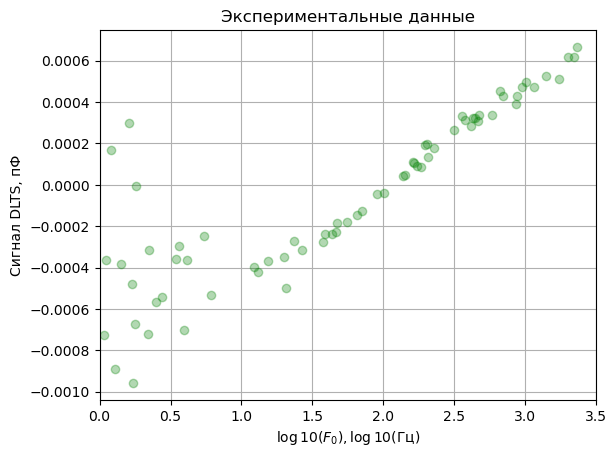

In [18]:
fig, ax = plot_experimental_points(X_test, y_test)
ax.set_xlim([0, 3.5])
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_test_data.pdf',
            bbox_inches='tight')
plt.show()

### 2.2. Идентификация моноэкспоненциальной модели с показателем $p$
Идентификация модели:

In [19]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train, initial_exps_params_=[[-3.0, 0.0002]])

2022-10-08 16:54:18.119478: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 16:54:18.119504: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 16:54:18.119509: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 16:54:18.119653: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 16:54:18.119668: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 16:54:18.119672: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 16:54:18.133121: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

SklSingleExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                          learning_rate=0.05, stop_val=1e-05)

Сохраняем модель

In [20]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_model_1.pkl'

# для сохранения модели
dump(monoexp_fs, f_name)

# для загрузки модели:
# monoexp_fs = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_model_1.pkl']

Вывод табличных результатов идентификации

In [21]:
fit_results_ = monoexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_fit_results_1.csv')
fit_results_.tail(10)

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
225,0.000533,0.00001,True,0.05,7.902869e-08,1,1000,0.810602,0.00001,-3.536037,False
226,0.000533,0.00001,True,0.05,7.902792e-08,1,1000,0.810239,0.00001,-3.536316,False
227,0.000533,0.00001,True,0.05,7.902715e-08,1,1000,0.809876,0.00001,-3.536594,False
228,0.000533,0.00001,True,0.05,7.902640e-08,1,1000,0.809514,0.00001,-3.536869,False
229,0.000533,0.00001,True,0.05,7.902567e-08,1,1000,0.809152,0.00001,-3.537143,False
230,0.000533,0.00001,True,0.05,7.902495e-08,1,1000,0.808791,0.00001,-3.537415,False
231,0.000534,0.00001,True,0.05,7.902424e-08,1,1000,0.808431,0.00001,-3.537685,False
232,0.000534,0.00001,True,0.05,7.902354e-08,1,1000,0.808071,0.00001,-3.537954,False
233,0.000534,0.00001,True,0.05,7.902286e-08,1,1000,0.807713,0.00001,-3.538220,False
234,0.000534,0.00001,True,0.05,7.902219e-08,1,1000,0.807354,0.00001,-3.538485,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

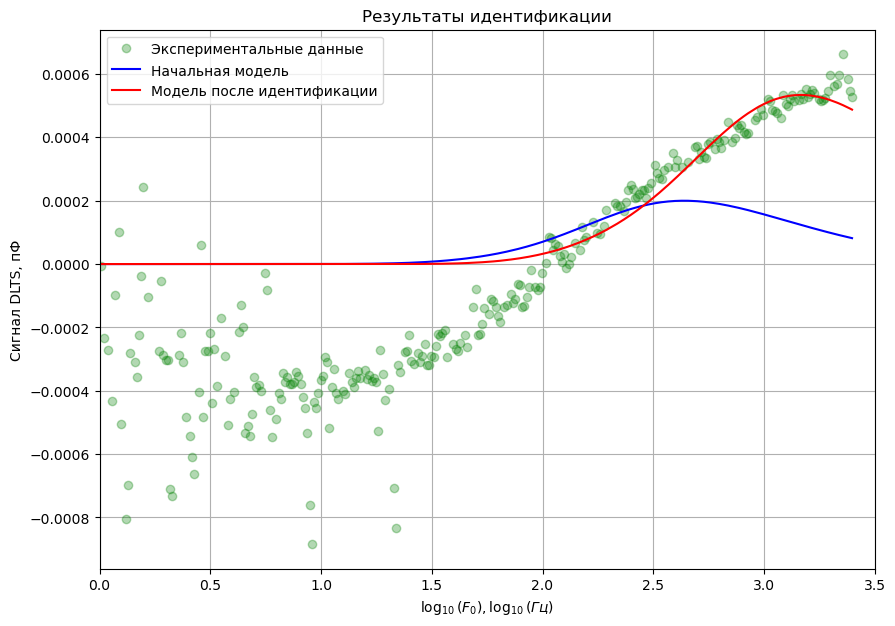

In [22]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, fit_results_, plot_exps=False)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_model_1.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации.

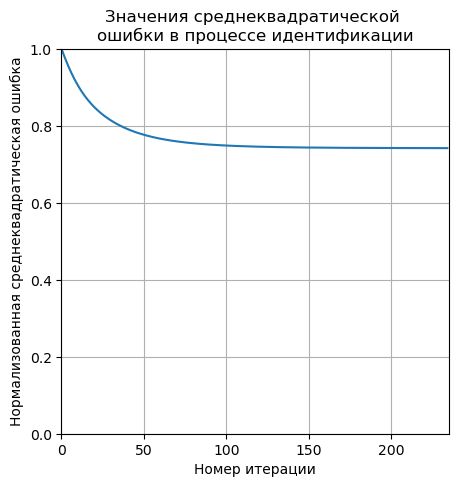

In [23]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_model_loss_1.pdf',
            bbox_inches='tight')
plt.show()

График выходит на "плато", что свидетельствует о том, что решение сошлось, однако довольно высокое значение среднеквадратической ошибки может указывать на то, что алгоритм нашёл локальный минимум функции потерь. О последнем также свидетельсвует предыдущий график (графика с экспериментальными данными и данными полученными на идентифицированной модели).

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных.

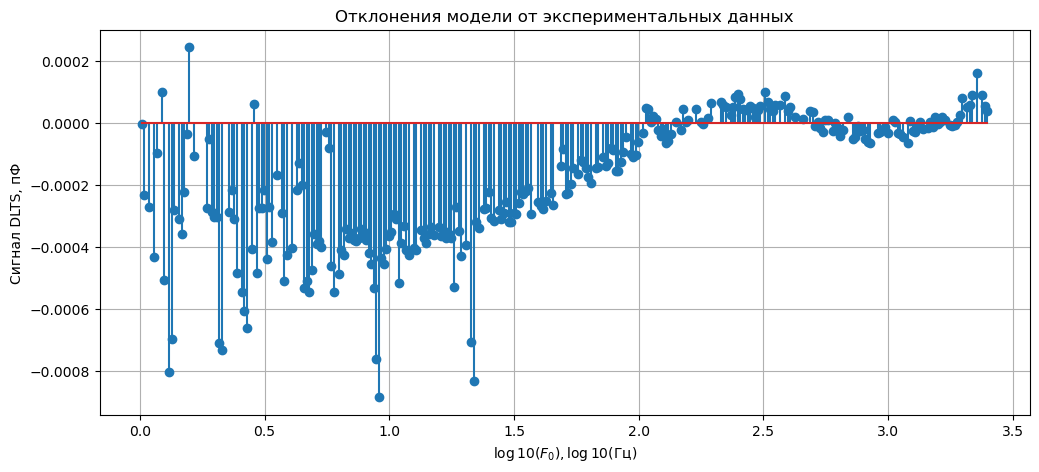

In [24]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, monoexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_deviations_1.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

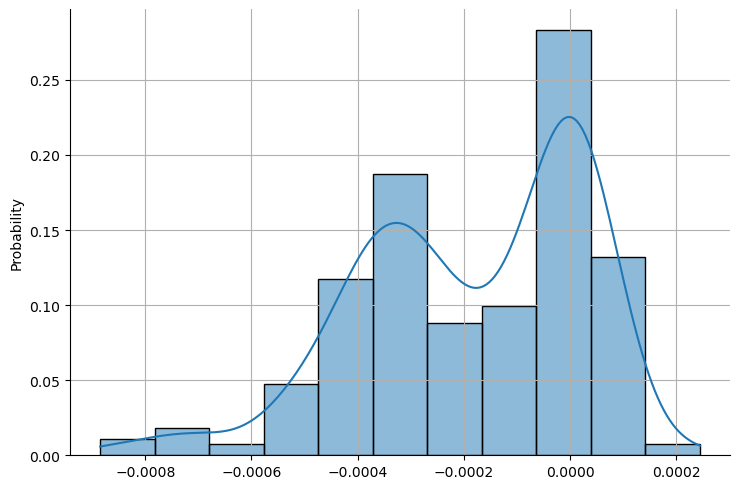

In [25]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_hist_1.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [16]:
def display_scores(scores):
    print('Scores - корни из среднеквадратических ошибок')
    scores = np.sqrt(-scores)
    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Standard deviation: {scores.std()}')

In [27]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train, 
                         fit_params=dict(initial_exps_params_=[[-3.0, 0.0002]]), 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-08 16:54:51.032432: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 16:54:51.032456: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 16:54:51.032465: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 16:54:51.032573: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 16:54:51.032585: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 16:54:51.032589: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 16:54:51.032698: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.00029281 0.00029454 0.0002831  0.0002712  0.00026233]
Mean: 0.0002807966237032519
Standard deviation: 1.2421250363559893e-05


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [28]:
mean_squared_error(y_train, monoexp_fs.predict(X_train), squared=False)

0.00028110886269098665

Оценим ту же метрику на тестовых данных

In [29]:
mean_squared_error(y_test, monoexp_fs.predict(X_test), squared=False)

0.00032577379513290555

Выведем на экран полученный спектр

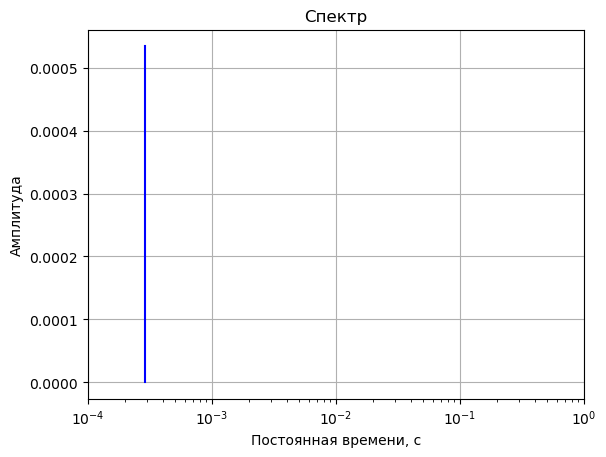

In [30]:
plot_spectr(monoexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_spectr_1.pdf',
            bbox_inches='tight')
plt.show()

Попробуем идентифицировать модель задав другую начальную точку для идентификации.

Идентификация модели с начальной точкой близкой к отрицательному пику

In [31]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train, initial_exps_params_=[[-1.5, -0.0002]])

SklSingleExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                          learning_rate=0.05, stop_val=1e-05)

Сохраим модель

In [32]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_model_2.pkl'

# для сохранения модели
dump(monoexp_fs, f_name)

# для загрузки модели:
# monoexp_fs = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_model_2.pkl']

Вывод табличных результатов идентификации

In [33]:
fit_results_ = monoexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_fit_results_2.csv')
monoexp_fs.fit_results_.tail(10)

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
165,-0.000464,0.00001,True,0.05,7.616906e-08,1,1000,1.098484,0.00001,-1.112102,False
166,-0.000465,0.00001,True,0.05,7.616821e-08,1,1000,1.099008,0.00001,-1.112184,False
167,-0.000465,0.00001,True,0.05,7.616738e-08,1,1000,1.099525,0.00001,-1.112265,False
168,-0.000465,0.00001,True,0.05,7.616658e-08,1,1000,1.100036,0.00001,-1.112344,False
169,-0.000465,0.00001,True,0.05,7.616580e-08,1,1000,1.100539,0.00001,-1.112423,False
170,-0.000465,0.00001,True,0.05,7.616504e-08,1,1000,1.101036,0.00001,-1.112501,False
171,-0.000465,0.00001,True,0.05,7.616431e-08,1,1000,1.101526,0.00001,-1.112577,False
172,-0.000466,0.00001,True,0.05,7.616361e-08,1,1000,1.102010,0.00001,-1.112653,False
173,-0.000466,0.00001,True,0.05,7.616292e-08,1,1000,1.102487,0.00001,-1.112728,False
174,-0.000466,0.00001,True,0.05,7.616226e-08,1,1000,1.102957,0.00001,-1.112802,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

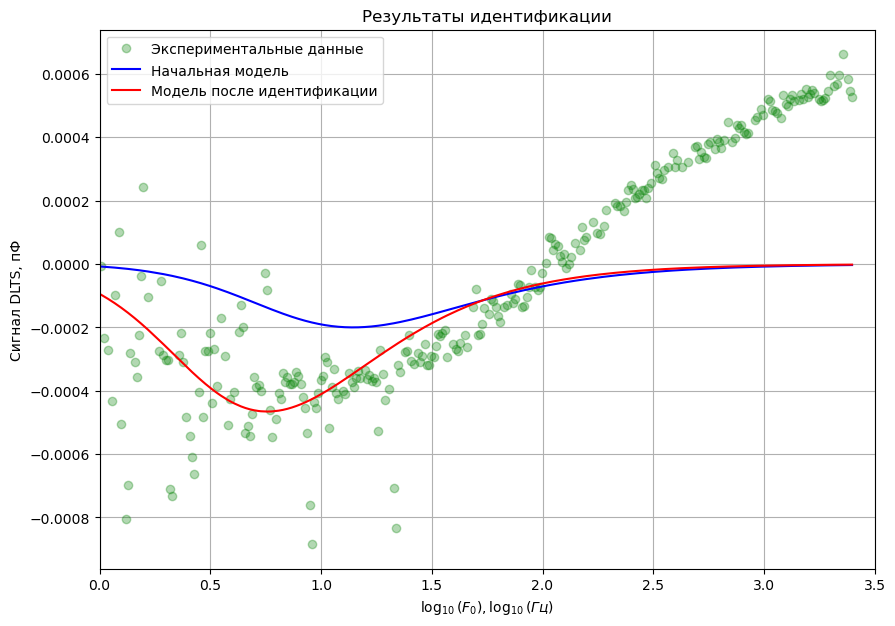

In [34]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, fit_results_, plot_exps=False)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_model_2.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации.

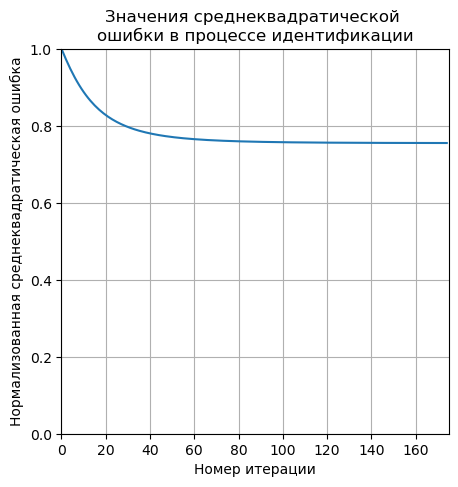

In [35]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_model_loss_2.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных.

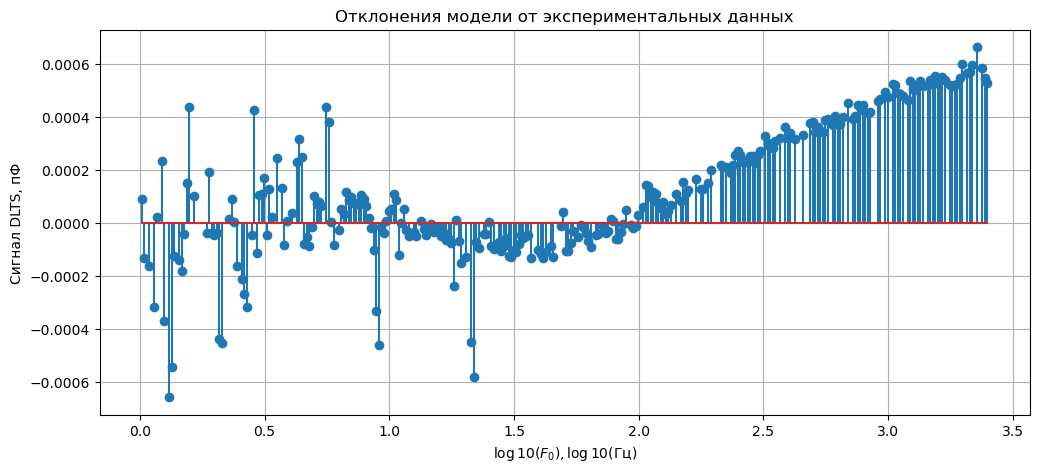

In [36]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, monoexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_deviations_2.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

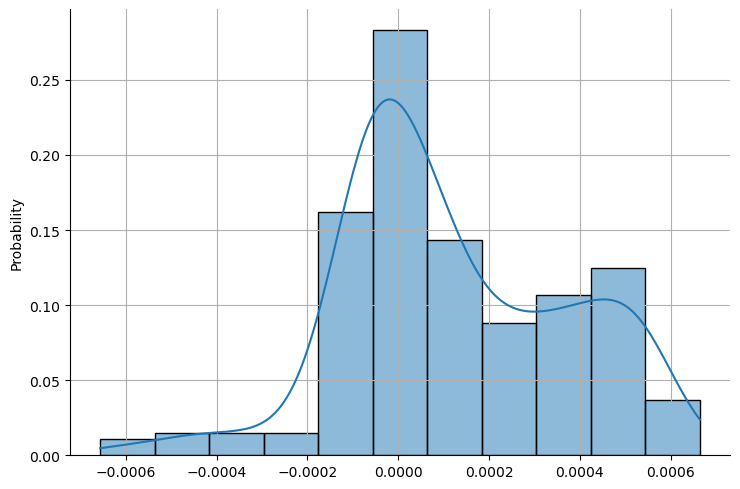

In [37]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_hist_2.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [38]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train, 
                         fit_params=dict(initial_exps_params_=[[-1.5, -0.0002]]), 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-08 16:55:48.822104: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 16:55:48.822128: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 16:55:48.822132: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 16:55:48.822238: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 16:55:48.822254: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 16:55:48.822258: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 16:55:48.822370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.00030161 0.00022981 0.00031517 0.00026068 0.00028272]
Mean: 0.0002779953774609912
Standard deviation: 3.027575076160385e-05


Оценим корень из среднеквадратической ошики между экспериментальными данными и данными, полученными на идентифицированной модели

In [39]:
mean_squared_error(y_train, monoexp_fs.predict(X_train), squared=False)

0.00027597509962941266

Оценим ту же метрику на тестовых данных

In [40]:
mean_squared_error(y_test, monoexp_fs.predict(X_test), squared=False)

0.00032653888665531245

Выведем на экран полученный спектр

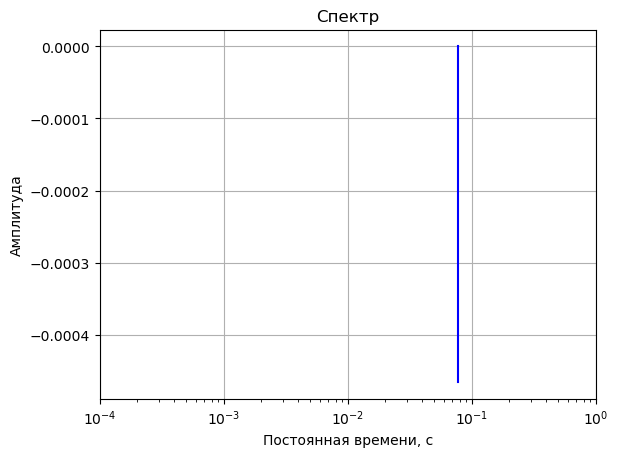

In [41]:
plot_spectr(monoexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_spectr_2.pdf',
            bbox_inches='tight')
plt.show()

### 2.3. Идентификация моноэкспоненциальной моделью с показателем $p=1$

Идентификация модели:

In [42]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False,
                                       fit_p_coef = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train)

SklSingleExpFrequencyScan(filling_pulse=9.999999999999999e-06, fit_p_coef=False,
                          learning_rate=0.05, stop_val=1e-05)

Сохраним модель

In [43]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_ideal.pkl'

# для сохранения модели
dump(monoexp_fs, f_name)

# для загрузки модели:
# monoexp_fs = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_ideal.pkl']

Вывод табличных результатов идентификации

In [44]:
fit_results_ = monoexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_ideal_fit_results.csv')
monoexp_fs.fit_results_.tail(10)

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
231,0.000532,0.00001,False,0.05,7.926045e-08,1,1000,1.0,0.00001,-3.481395,False
232,0.000532,0.00001,False,0.05,7.925961e-08,1,1000,1.0,0.00001,-3.481550,False
233,0.000532,0.00001,False,0.05,7.925879e-08,1,1000,1.0,0.00001,-3.481703,False
234,0.000532,0.00001,False,0.05,7.925799e-08,1,1000,1.0,0.00001,-3.481854,False
235,0.000532,0.00001,False,0.05,7.925722e-08,1,1000,1.0,0.00001,-3.482002,False
236,0.000533,0.00001,False,0.05,7.925647e-08,1,1000,1.0,0.00001,-3.482148,False
237,0.000533,0.00001,False,0.05,7.925575e-08,1,1000,1.0,0.00001,-3.482292,False
238,0.000533,0.00001,False,0.05,7.925505e-08,1,1000,1.0,0.00001,-3.482434,False
239,0.000533,0.00001,False,0.05,7.925436e-08,1,1000,1.0,0.00001,-3.482574,False
240,0.000533,0.00001,False,0.05,7.925370e-08,1,1000,1.0,0.00001,-3.482712,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

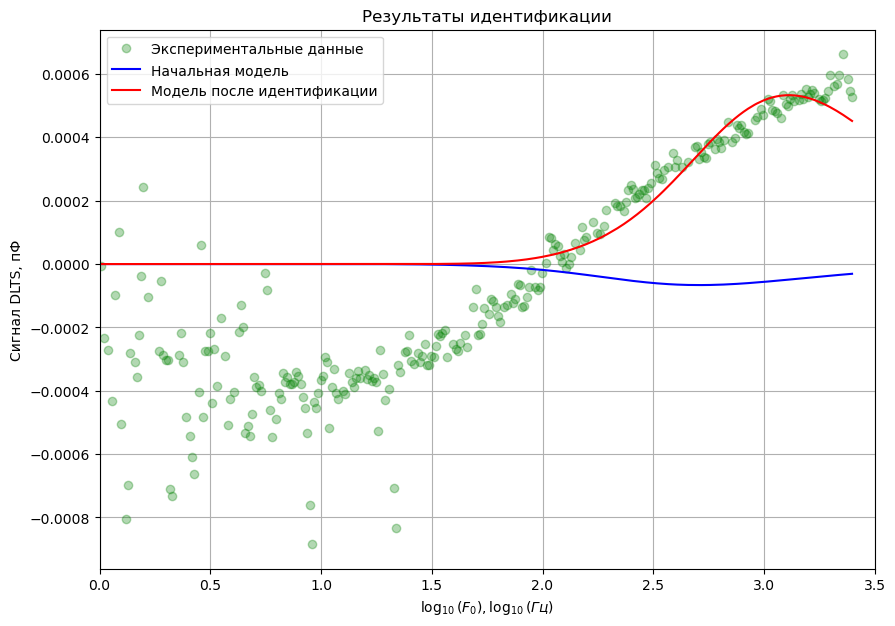

In [45]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, fit_results_, plot_exps=False)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_ideal_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации.

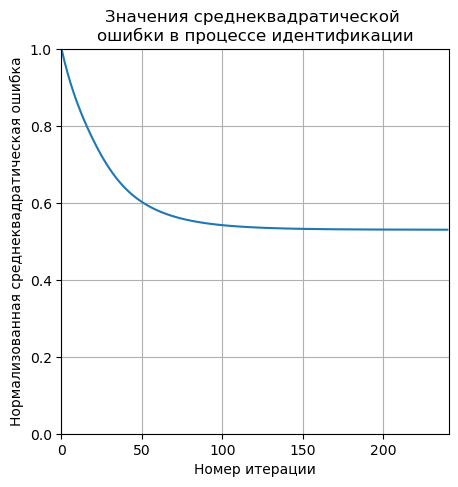

In [46]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_ideal_model_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных.

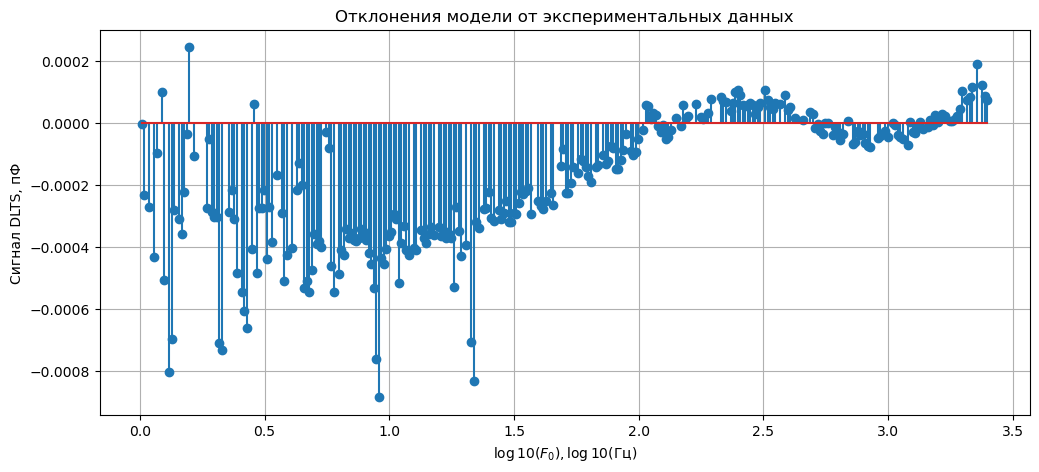

In [47]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, monoexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_ideal_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

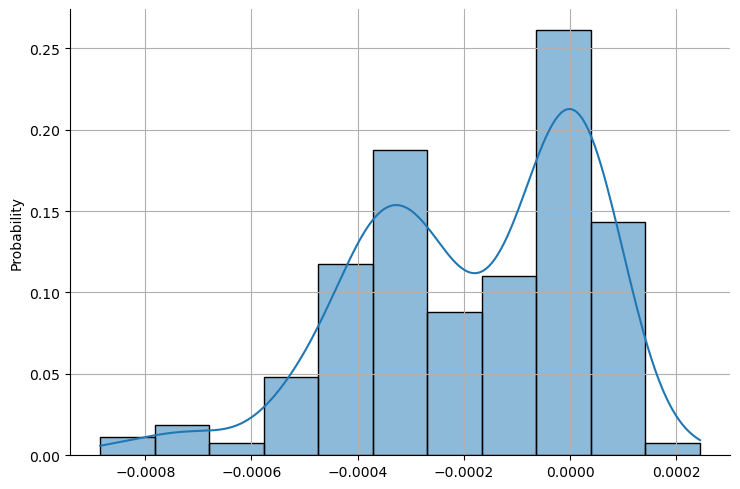

In [48]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_ideal_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [49]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-08 16:56:47.664085: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 16:56:47.664109: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 16:56:47.664115: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 16:56:47.664215: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 16:56:47.664228: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 16:56:47.664232: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 16:56:47.664337: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.00029318 0.00029458 0.0002839  0.00026153 0.00028126]
Mean: 0.00028288959934035597
Standard deviation: 1.1850765517395898e-05


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [50]:
mean_squared_error(y_train, monoexp_fs.predict(X_train), squared=False)

0.00028152034036491225

Оценим ту же метрику на тестовых данных

In [51]:
mean_squared_error(y_test, monoexp_fs.predict(X_test), squared=False)

0.0003265257124340932

Выведем на экран полученный спектр

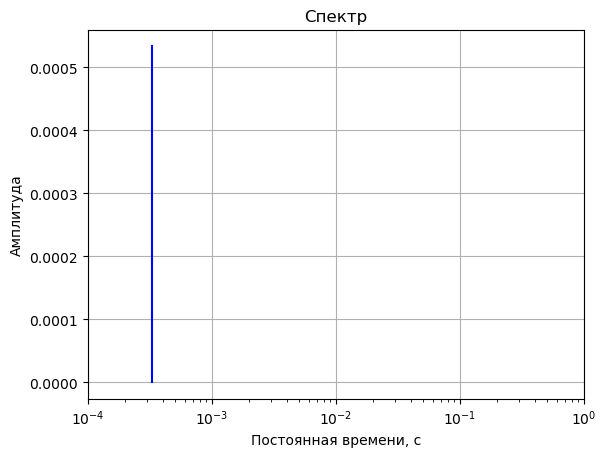

In [52]:
plot_spectr(monoexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_single_exp_ideal_spectr.pdf',
            bbox_inches='tight')
plt.show()

### 2.4. Идентификация мультиэкспоненциальной модели с n_exps>1

Идентификация мультиэкспоненциальной модели

In [53]:
multiexp_fs = SklMultiExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5
                                      )

In [54]:
param_grid = {'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(multiexp_fs, param_grid, cv=5, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=23)

In [55]:
grid_search.fit(X_train, y_train)

2022-10-08 16:57:34.416569: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 16:57:34.416599: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 16:57:34.416603: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 16:57:34.416807: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 16:57:34.416824: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 16:57:34.416828: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 16:57:34.417024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

GridSearchCV(cv=5,
             estimator=SklMultiExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                                                learning_rate=0.05,
                                                stop_val=1e-05),
             n_jobs=23, param_grid={'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True, scoring='neg_mean_squared_error')

Лучший результат показала модель со следующим количеством экспоненциальных составляющих (n_exps)

In [56]:
grid_search.best_params_

{'n_exps': 6}

Сохраним объект GridSearchCV

In [57]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multiexp_grid_search.pkl'

# для сохранения модели
dump(grid_search, f_name)

# для загрузки модели:
# grid_search = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multiexp_grid_search.pkl']

Ниже приведены результаты, которые показали модули с другими занчениями параметра (n_exps)

In [58]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.00027052143066013583 {'n_exps': 1}
0.00021169870195620073 {'n_exps': 2}
0.0001679934533346909 {'n_exps': 3}
0.00012484132743766164 {'n_exps': 4}
0.00012293404500178208 {'n_exps': 5}
0.0001209198540803597 {'n_exps': 6}
0.00012121828909678268 {'n_exps': 7}
0.00012163082563737284 {'n_exps': 8}
0.00012103295597937151 {'n_exps': 9}
0.00012204351566715799 {'n_exps': 10}


Сохраним лучшую модель

In [59]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multiexp_best_estimator_.pkl'

# для сохранения модели
dump(grid_search.best_estimator_, f_name)

# для загрузки модели:
# best_estimator_ = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multiexp_best_estimator_.pkl']

Для лучшей модели выведем табличные результаты и графики.

Вывод табличных результатов идентификации

In [60]:
multiexp_fs = grid_search.best_estimator_
fit_results_ = multiexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multi_exp_fit_results_1.csv')
multiexp_fs.fit_results_.tail(10)

,amplitude_0,amplitude_1,amplitude_2,amplitude_3,amplitude_4,amplitude_5,filling_pulse,learning_rate,loss,n_exps,n_iters,stop_val,time_constant_pow_0,time_constant_pow_1,time_constant_pow_2,time_constant_pow_3,time_constant_pow_4,time_constant_pow_5,verbose
524,-0.000178,0.000386,-0.000223,0.000029,-0.000199,0.000296,0.00001,0.05,1.329639e-08,6,1000,0.00001,-1.221396,-3.815518,-0.596658,-2.177716,-1.678084,-3.076319,False
525,-0.000178,0.000386,-0.000223,0.000029,-0.000199,0.000296,0.00001,0.05,1.329568e-08,6,1000,0.00001,-1.221534,-3.815721,-0.596409,-2.177802,-1.678095,-3.076271,False
526,-0.000178,0.000386,-0.000223,0.000029,-0.000199,0.000296,0.00001,0.05,1.329497e-08,6,1000,0.00001,-1.221673,-3.815923,-0.596161,-2.177887,-1.678106,-3.076224,False
527,-0.000178,0.000386,-0.000223,0.000029,-0.000199,0.000296,0.00001,0.05,1.329426e-08,6,1000,0.00001,-1.221811,-3.816124,-0.595915,-2.177972,-1.678117,-3.076176,False
528,-0.000178,0.000387,-0.000223,0.000029,-0.000199,0.000296,0.00001,0.05,1.329356e-08,6,1000,0.00001,-1.221948,-3.816325,-0.595671,-2.178057,-1.678128,-3.076129,False
529,-0.000178,0.000387,-0.000223,0.000029,-0.000199,0.000297,0.00001,0.05,1.329287e-08,6,1000,0.00001,-1.222085,-3.816524,-0.595428,-2.178142,-1.678140,-3.076083,False
530,-0.000178,0.000387,-0.000223,0.000029,-0.000200,0.000297,0.00001,0.05,1.329218e-08,6,1000,0.00001,-1.222221,-3.816723,-0.595186,-2.178226,-1.678151,-3.076036,False
531,-0.000178,0.000387,-0.000223,0.000029,-0.000200,0.000297,0.00001,0.05,1.329149e-08,6,1000,0.00001,-1.222356,-3.816920,-0.594946,-2.178310,-1.678162,-3.075990,False
532,-0.000178,0.000387,-0.000223,0.000030,-0.000200,0.000297,0.00001,0.05,1.329081e-08,6,1000,0.00001,-1.222491,-3.817117,-0.594707,-2.178394,-1.678173,-3.075944,False
533,-0.000178,0.000387,-0.000223,0.000030,-0.000200,0.000297,0.00001,0.05,1.329013e-08,6,1000,0.00001,-1.222626,-3.817313,-0.594469,-2.178478,-1.678185,-3.075898,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

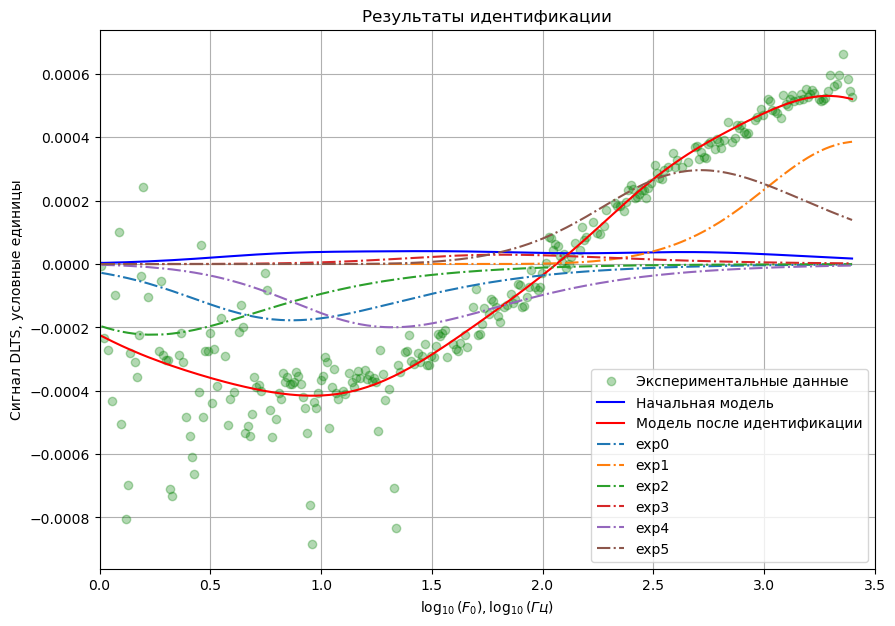

In [61]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multi_exp_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации

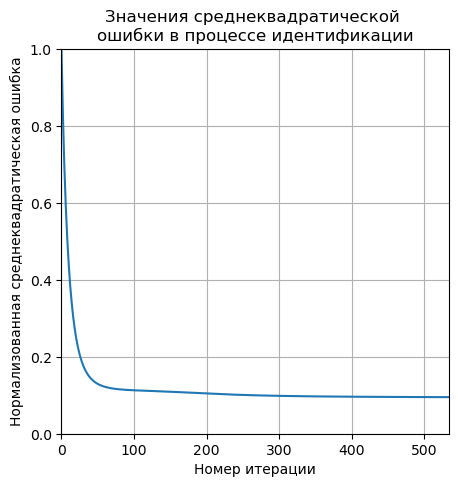

In [62]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multi_exp_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных

In [63]:
y_pred = multiexp_fs.predict(X_train)

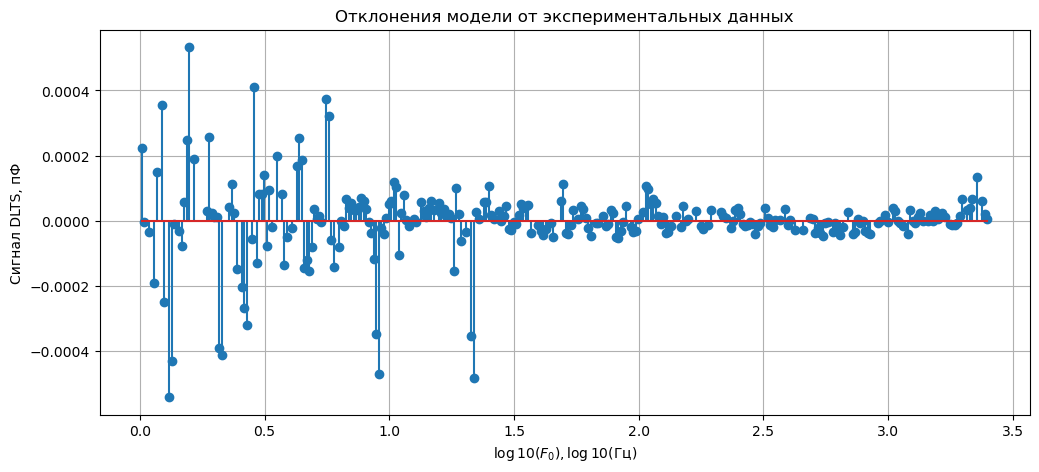

In [64]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, y_pred, ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multi_exp_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

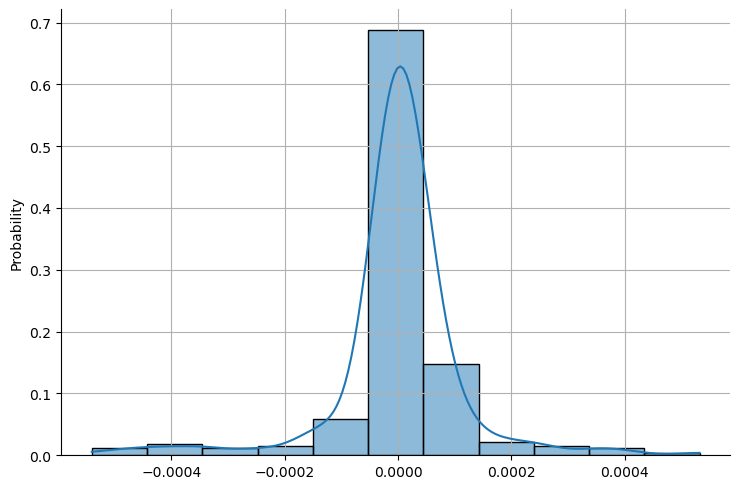

In [65]:
sns.displot(x=y_train - y_pred, bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multi_exp_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [66]:
# можно не делать, так как эта оценка есть в объекте grid_search

scores = cross_val_score(multiexp_fs, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-08 17:32:44.396405: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 17:32:44.396428: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 17:32:44.396436: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 17:32:44.396541: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 17:32:44.396554: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 17:32:44.396557: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 17:32:44.396666: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.00011756 0.00010685 0.0001515  0.0001225  0.00010465]
Mean: 0.00012060986739499712
Standard deviation: 1.679974646551825e-05


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [67]:
mean_squared_error(y_train, y_pred, squared=False)

0.00011528284246283684

Оценим ту же метрику на тестовых данных

In [68]:
mean_squared_error(y_test, multiexp_fs.predict(X_test), squared=False)

0.0001866259765890857

Выведем на экран полученный спектр

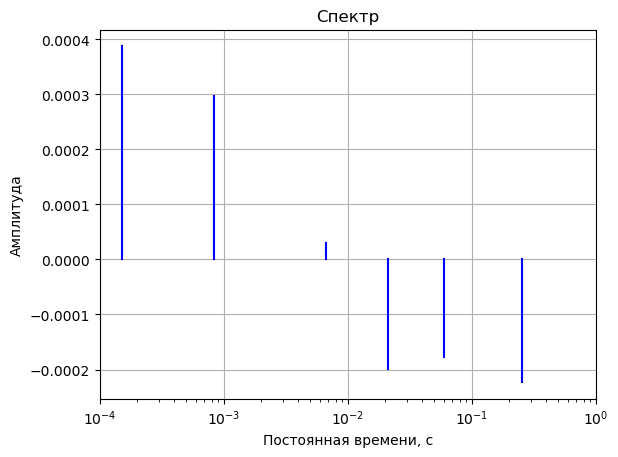

In [69]:
plot_spectr(multiexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01_multi_exp_spectr.pdf',
            bbox_inches='tight')
plt.show()

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate

https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [70]:
multiexp_fs = SklMultiExpFrequencyScan(n_exps=5,
                                       filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5
                                      )

In [71]:
initial_exps_params = [[-3.0, 0.0002], 
                       [-3.5, 0.0004],
                       [-1.5, -0.0002],
                       [-1.0, -0.0002],
                       [-2.0, -0.0002]
                      ]
multiexp_fs.fit(X_train, y_train, initial_exps_params_=initial_exps_params)

SklMultiExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                         learning_rate=0.05, n_exps=5, stop_val=1e-05)

In [72]:
fit_results_ = multiexp_fs.fit_results_.copy()
fit_results_.tail(10)

,amplitude_0,amplitude_1,amplitude_2,amplitude_3,amplitude_4,filling_pulse,learning_rate,loss,n_exps,n_iters,stop_val,time_constant_pow_0,time_constant_pow_1,time_constant_pow_2,time_constant_pow_3,time_constant_pow_4,verbose
229,0.00024,0.000455,-0.000196,-0.000247,-0.000153,0.00001,0.05,1.325680e-08,5,1000,0.00001,-2.870671,-3.713657,-1.315852,-0.658963,-1.782985,False
230,0.00024,0.000455,-0.000196,-0.000247,-0.000153,0.00001,0.05,1.325607e-08,5,1000,0.00001,-2.870778,-3.713914,-1.316055,-0.658622,-1.782665,False
231,0.00024,0.000456,-0.000196,-0.000247,-0.000153,0.00001,0.05,1.325534e-08,5,1000,0.00001,-2.870885,-3.714169,-1.316257,-0.658283,-1.782346,False
232,0.00024,0.000456,-0.000196,-0.000247,-0.000153,0.00001,0.05,1.325462e-08,5,1000,0.00001,-2.870992,-3.714423,-1.316457,-0.657946,-1.782029,False
233,0.00024,0.000456,-0.000196,-0.000247,-0.000153,0.00001,0.05,1.325391e-08,5,1000,0.00001,-2.871098,-3.714676,-1.316657,-0.657612,-1.781712,False
234,0.00024,0.000456,-0.000196,-0.000247,-0.000153,0.00001,0.05,1.325320e-08,5,1000,0.00001,-2.871205,-3.714927,-1.316855,-0.657280,-1.781398,False
235,0.00024,0.000456,-0.000196,-0.000247,-0.000153,0.00001,0.05,1.325251e-08,5,1000,0.00001,-2.871312,-3.715177,-1.317052,-0.656951,-1.781084,False
236,0.00024,0.000456,-0.000196,-0.000247,-0.000153,0.00001,0.05,1.325182e-08,5,1000,0.00001,-2.871419,-3.715426,-1.317248,-0.656623,-1.780772,False
237,0.00024,0.000456,-0.000196,-0.000248,-0.000153,0.00001,0.05,1.325114e-08,5,1000,0.00001,-2.871526,-3.715673,-1.317443,-0.656299,-1.780461,False
238,0.00024,0.000456,-0.000196,-0.000248,-0.000153,0.00001,0.05,1.325047e-08,5,1000,0.00001,-2.871633,-3.715919,-1.317637,-0.655976,-1.780152,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

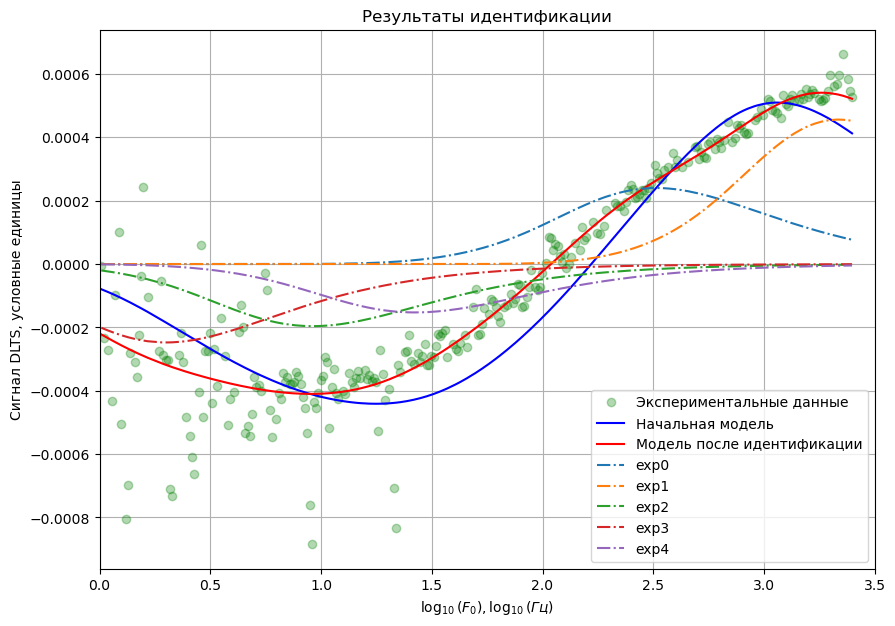

In [73]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, fit_results_)
plt.show()

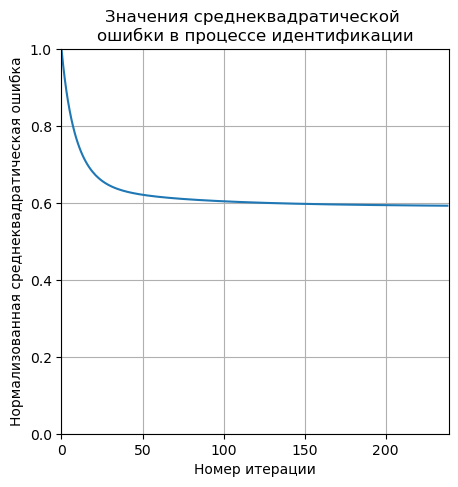

In [74]:
plot_loss_path(fit_results_)
plt.show()

In [75]:
y_pred = multiexp_fs.predict(X_train)

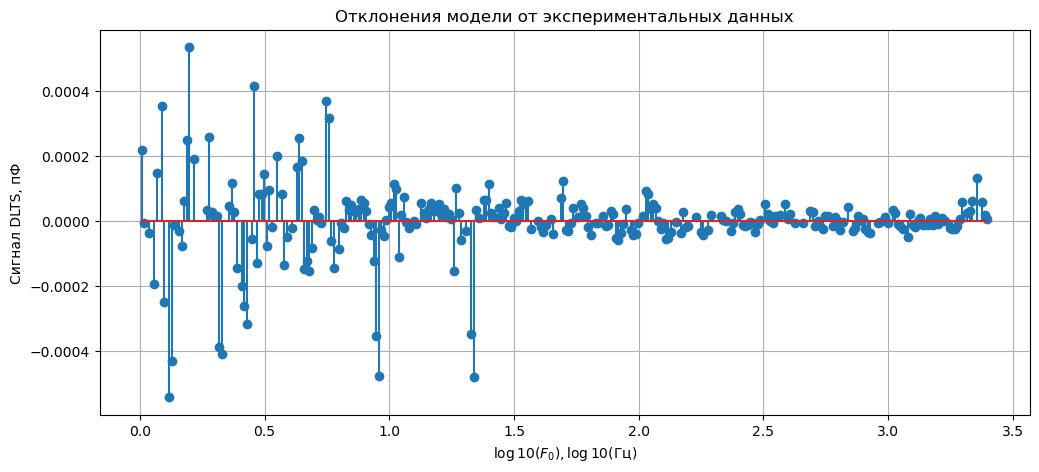

In [76]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, y_pred, ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.show()

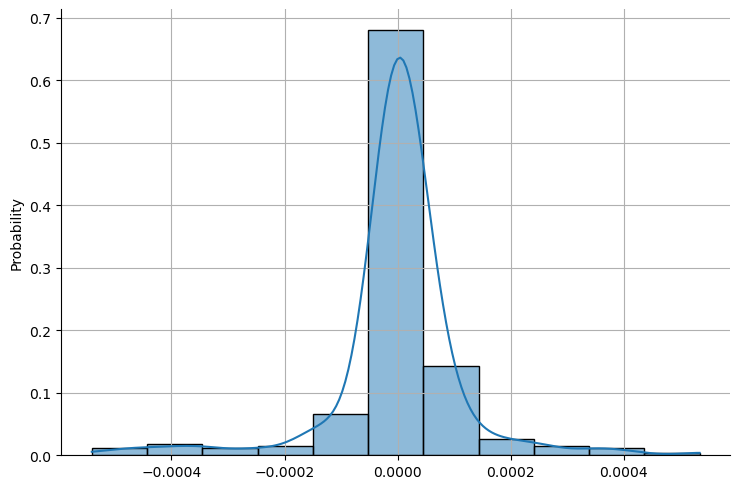

In [77]:
sns.displot(x=y_train - y_pred, bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()

plt.show()

In [78]:
scores = cross_val_score(multiexp_fs, 
                         X_train, 
                         y_train, 
                         fit_params=dict(initial_exps_params_=initial_exps_params), 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-08 17:42:51.068393: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 17:42:51.068413: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 17:42:51.068422: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 17:42:51.068521: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 17:42:51.068534: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 17:42:51.068537: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 17:42:51.068638: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.000117   0.00010608 0.00015213 0.00011855 0.00010502]
Mean: 0.00011975772491603178
Standard deviation: 1.709741889312256e-05


In [79]:
mean_squared_error(y_train, y_pred, squared=False)

0.00011511068462328718

In [80]:
mean_squared_error(y_test, multiexp_fs.predict(X_test), squared=False)

0.00018630582770078026

Выведем на экран полученный спектр

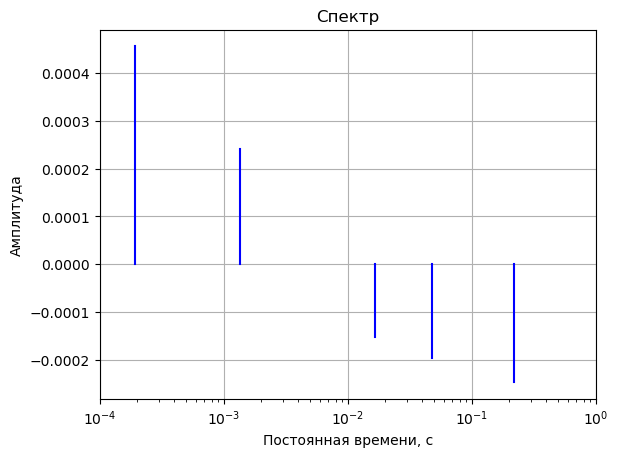

In [81]:
plot_spectr(multiexp_fs.exps_params_, xlim=[1/10000, 1])
plt.show()

## 3. 1564ЛЕ1№1\_п1\_2500Гц-1Гц\_1пФ\_+10С\_-4В-5В\_50мВ\_10мкс\_шаг\_0,01.csv
### 3.1. Подготовка экспериментальных данных

Чтение данных

In [82]:
print(data_frames[1][0])

1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01.csv


In [83]:
filling_pulse, X_train, y_train, X_test, y_test = get_X_y(data_frames[1][1])

Выведем тренировачный набор данных

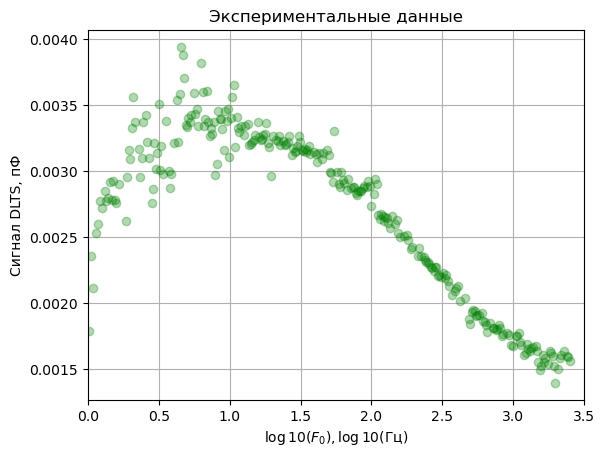

In [84]:
fig, ax = plot_experimental_points(X_train, y_train)
ax.set_xlim([0, 3.5])
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_train_data.pdf',
            bbox_inches='tight')
plt.show()

Выведем тестовый набор данных

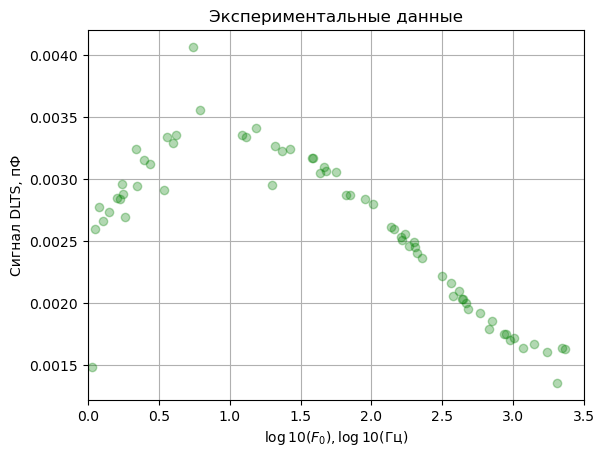

In [85]:
fig, ax = plot_experimental_points(X_test, y_test)
ax.set_xlim([0, 3.5])
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_test_data.pdf',
            bbox_inches='tight')
plt.show()

### 3.2. Идентификация моноэкспоненциальной модели с показателем $p$

Идентификация модели:

In [86]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train)

SklSingleExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                          learning_rate=0.05, stop_val=1e-05)

Сохраняем модель

In [87]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_model.pkl'

# для сохранения модели
dump(monoexp_fs, f_name)

# для загрузки модели:
# monoexp_fs = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_model.pkl']

Вывод табличных результатов идентификации

In [88]:
fit_results_ = monoexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_fit_results.csv')
fit_results_.tail(10)

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
147,0.003434,0.00001,True,0.05,2.439441e-08,1,1000,0.170575,0.00001,-1.260539,False
148,0.003435,0.00001,True,0.05,2.437106e-08,1,1000,0.170692,0.00001,-1.260356,False
149,0.003436,0.00001,True,0.05,2.434942e-08,1,1000,0.170807,0.00001,-1.260186,False
150,0.003437,0.00001,True,0.05,2.432937e-08,1,1000,0.170917,0.00001,-1.260027,False
151,0.003438,0.00001,True,0.05,2.431080e-08,1,1000,0.171024,0.00001,-1.259879,False
152,0.003439,0.00001,True,0.05,2.429358e-08,1,1000,0.171127,0.00001,-1.259742,False
153,0.003440,0.00001,True,0.05,2.427763e-08,1,1000,0.171227,0.00001,-1.259614,False
154,0.003440,0.00001,True,0.05,2.426284e-08,1,1000,0.171324,0.00001,-1.259495,False
155,0.003441,0.00001,True,0.05,2.424912e-08,1,1000,0.171417,0.00001,-1.259384,False
156,0.003442,0.00001,True,0.05,2.423640e-08,1,1000,0.171508,0.00001,-1.259282,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

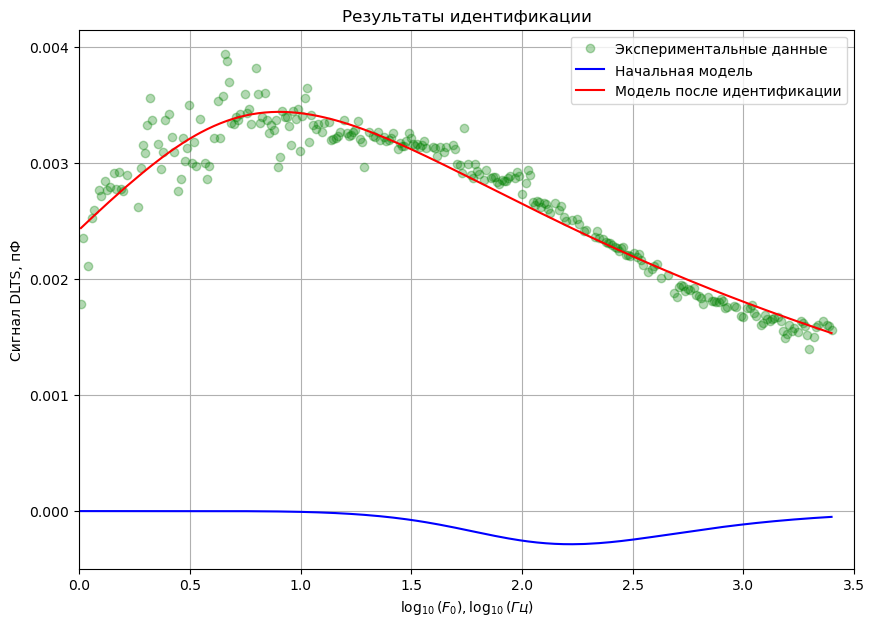

In [89]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, fit_results_, plot_exps=False)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации.

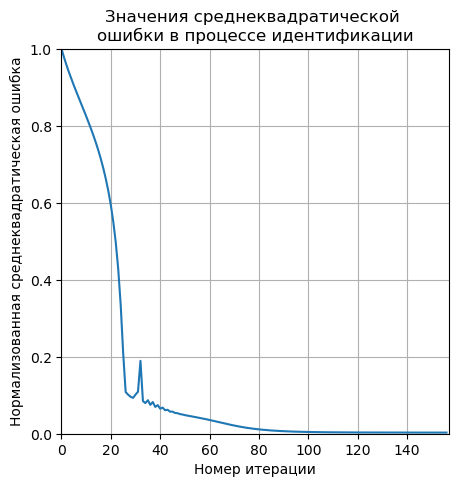

In [90]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_model_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных.

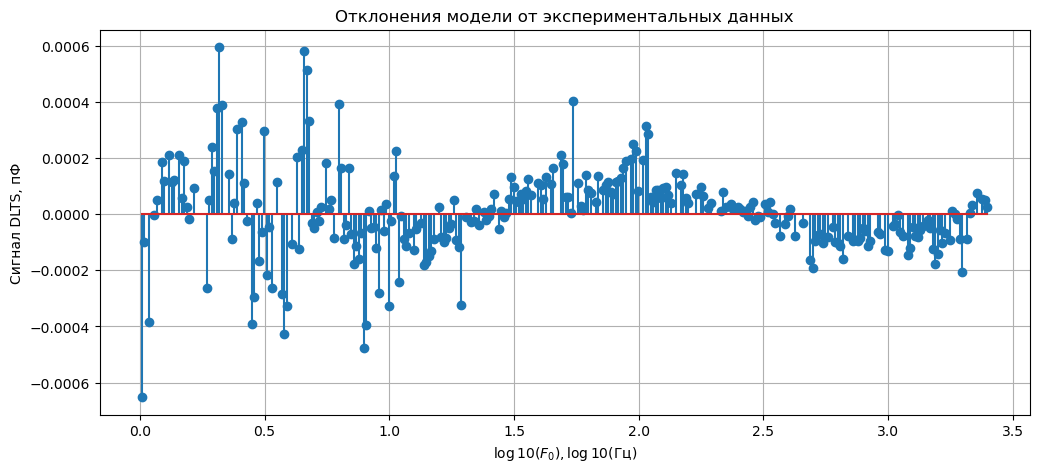

In [91]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, monoexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

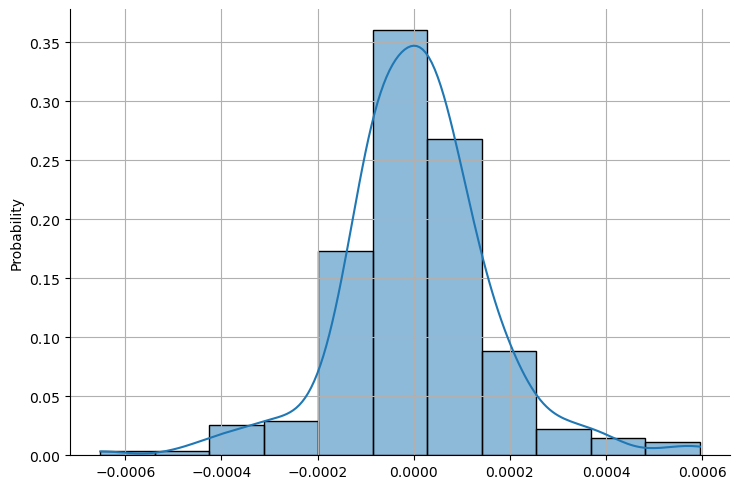

In [92]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [93]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train,
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-08 17:46:09.524818: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 17:46:09.524838: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 17:46:09.524843: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 17:46:09.524970: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 17:46:09.524984: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 17:46:09.524988: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 17:46:09.525093: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.00014694 0.00014946 0.00015045 0.00016295 0.00270691]
Mean: 0.0006633411487273541
Standard deviation: 0.0010217997228091236


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [94]:
mean_squared_error(y_train, monoexp_fs.predict(X_train), squared=False)

0.00015568045145391418

Оценим ту же метрику на тестовых данных

In [95]:
mean_squared_error(y_test, monoexp_fs.predict(X_test), squared=False)

0.00018221128551647534

Выведем на экран полученный спектр

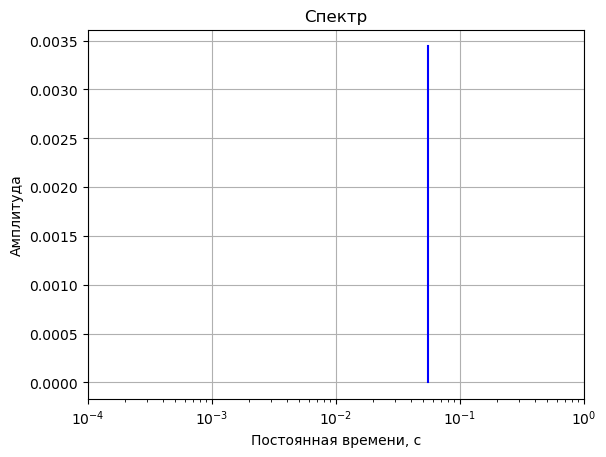

In [96]:
plot_spectr(monoexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_spectr.pdf',
            bbox_inches='tight')
plt.show()

### 3.3. Идентификация моноэкспоненциальной моделью с показателем $p=1$

Идентификация модели:

In [97]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False,
                                       fit_p_coef = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train)

SklSingleExpFrequencyScan(filling_pulse=9.999999999999999e-06, fit_p_coef=False,
                          learning_rate=0.05, stop_val=1e-05)

Сохраним модель

In [98]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_ideal.pkl'

# для сохранения модели
dump(monoexp_fs, f_name)

# для загрузки модели:
# monoexp_fs = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_ideal.pkl']

Вывод табличных результатов идентификации

In [99]:
fit_results_ = monoexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_ideal_fit_results.csv')
monoexp_fs.fit_results_.tail(10)

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
228,0.004471,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.372390,False
229,0.004472,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.372392,False
230,0.004473,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.372393,False
231,0.004474,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.372395,False
232,0.004474,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.372396,False
233,0.004475,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.372398,False
234,0.004476,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.372399,False
235,0.004477,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.372401,False
236,0.004478,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.372402,False
237,0.004479,0.00001,False,0.05,0.000002,1,1000,1.0,0.00001,-1.372403,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

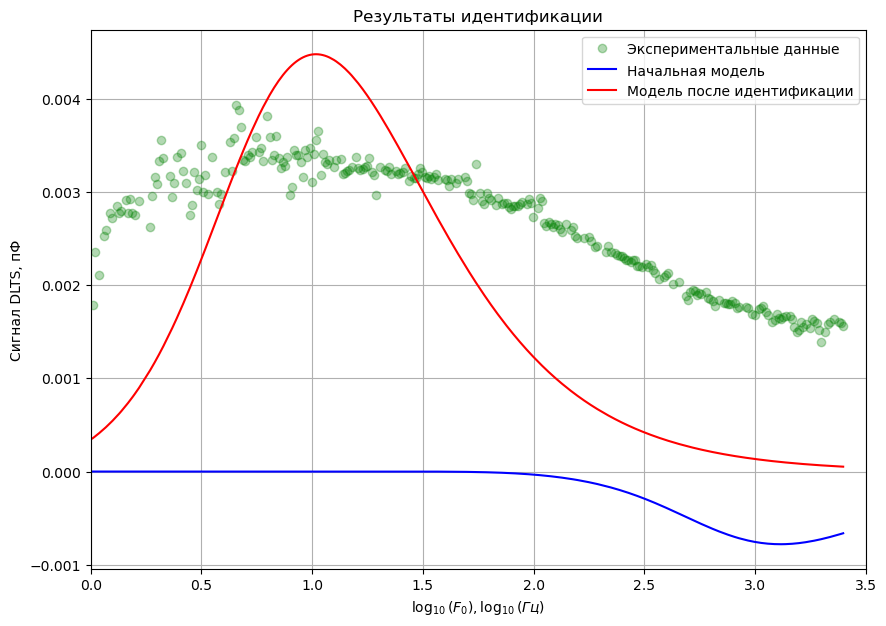

In [100]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, fit_results_, plot_exps=False)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_ideal_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации

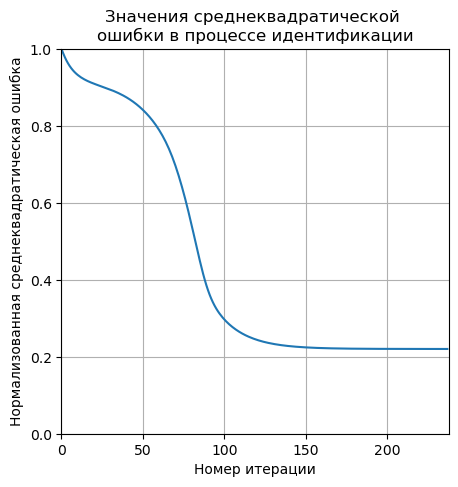

In [101]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_ideal_model_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных

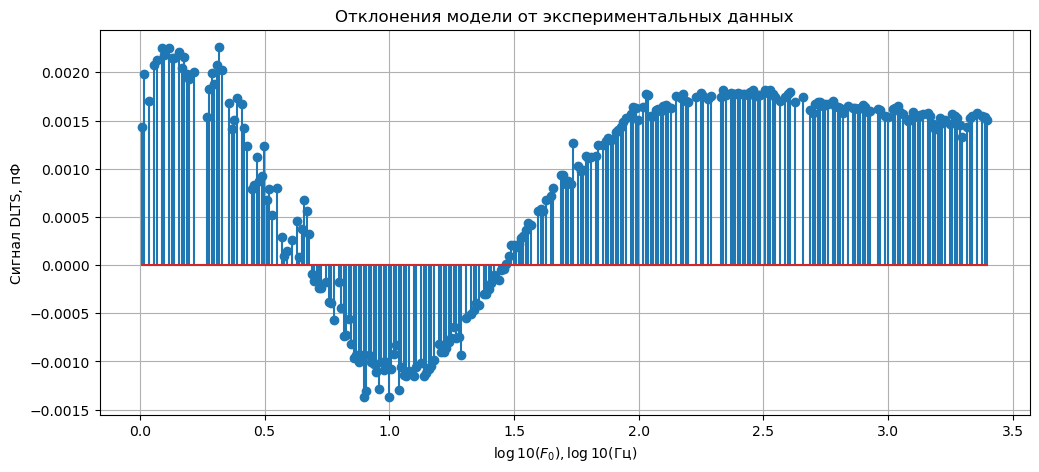

In [102]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, monoexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_ideal_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

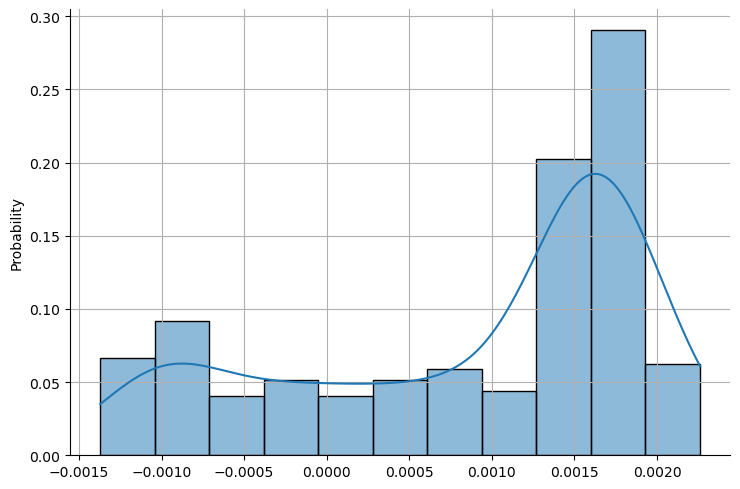

In [103]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_ideal_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [104]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-08 17:47:05.326661: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 17:47:05.326682: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 17:47:05.326687: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 17:47:05.326796: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 17:47:05.326810: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 17:47:05.326815: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 17:47:05.326931: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.00140745 0.0013132  0.00136858 0.00139887 0.00142146]
Mean: 0.001381912450552814
Standard deviation: 3.847901065660054e-05


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [105]:
mean_squared_error(y_train, monoexp_fs.predict(X_train), squared=False)

0.0013669790338625407

Оценим ту же метрику на тестовых данных

In [106]:
mean_squared_error(y_test, monoexp_fs.predict(X_test), squared=False)

0.0014869449324425442

Выведем на экран полученный спектр

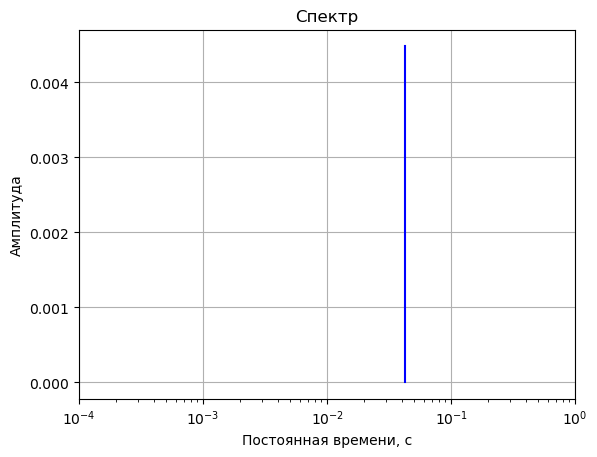

In [107]:
plot_spectr(monoexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_ideal_spectr.pdf',
            bbox_inches='tight')
plt.show()

### 3.4. Идентификация мультиэкспоненциальной модели с n_exps>1

Идентификация мультиэкспоненциальной модели

In [108]:
multiexp_fs = SklMultiExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5
                                      )

In [109]:
param_grid = {'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(multiexp_fs, param_grid, cv=5, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=23)

In [110]:
grid_search.fit(X_train, y_train)

2022-10-08 17:47:33.392570: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 17:47:33.392600: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 17:47:33.392605: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 17:47:33.392804: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 17:47:33.392821: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 17:47:33.392825: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 17:47:33.393016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

GridSearchCV(cv=5,
             estimator=SklMultiExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                                                learning_rate=0.05,
                                                stop_val=1e-05),
             n_jobs=23, param_grid={'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True, scoring='neg_mean_squared_error')

Лучший результат показала модель со следующим количеством экспоненциальных составляющих (n_exps)

In [111]:
grid_search.best_params_

{'n_exps': 10}

Сохраним объект GridSearchCV

In [112]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multiexp_grid_search.pkl'

# для сохранения модели
dump(grid_search, f_name)

# для загрузки модели:
# grid_search = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multiexp_grid_search.pkl']

Ниже приведены результаты, которые показали модули с другими занчениями параметра (n_exps)

In [113]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.0013824499915157107 {'n_exps': 1}
0.0005729140751525503 {'n_exps': 2}
0.00024307064284600846 {'n_exps': 3}
0.00015992434819603484 {'n_exps': 4}
0.0001508227712728854 {'n_exps': 5}
0.00015178555047026115 {'n_exps': 6}
0.00015077100651763779 {'n_exps': 7}
0.00015331154873010839 {'n_exps': 8}
0.00015060011213954169 {'n_exps': 9}
0.00014922262551455396 {'n_exps': 10}


Сохраним лучшую модель

In [114]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multiexp_best_estimator_.pkl'

# для сохранения модели
dump(grid_search.best_estimator_, f_name)

# для загрузки модели:
# best_estimator_ = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multiexp_best_estimator_.pkl']

Для лучшей модели выведем табличные результаты и графики.

Вывод табличных результатов идентификации

In [115]:
multiexp_fs = grid_search.best_estimator_
fit_results_ = multiexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multi_exp_fit_results_1.csv')
multiexp_fs.fit_results_.tail(10)

,amplitude_0,amplitude_1,amplitude_2,amplitude_3,amplitude_4,amplitude_5,amplitude_6,amplitude_7,amplitude_8,amplitude_9,...,time_constant_pow_1,time_constant_pow_2,time_constant_pow_3,time_constant_pow_4,time_constant_pow_5,time_constant_pow_6,time_constant_pow_7,time_constant_pow_8,time_constant_pow_9,verbose
339,0.001404,0.000194,0.000824,0.000616,0.000299,0.000648,0.001520,0.000348,0.001568,0.000470,...,-3.057846,-2.084032,-3.664645,-3.020616,-2.285570,-1.542791,-3.335348,-0.676099,-2.555941,False
340,0.001404,0.000194,0.000824,0.000616,0.000299,0.000648,0.001520,0.000348,0.001568,0.000470,...,-3.057797,-2.084011,-3.665102,-3.020526,-2.285650,-1.542614,-3.335505,-0.675857,-2.555942,False
341,0.001404,0.000194,0.000824,0.000617,0.000299,0.000648,0.001520,0.000348,0.001568,0.000470,...,-3.057748,-2.083990,-3.665557,-3.020435,-2.285730,-1.542437,-3.335661,-0.675615,-2.555944,False
342,0.001404,0.000194,0.000824,0.000617,0.000299,0.000648,0.001521,0.000348,0.001568,0.000470,...,-3.057699,-2.083969,-3.666011,-3.020343,-2.285810,-1.542261,-3.335815,-0.675373,-2.555947,False
343,0.001404,0.000194,0.000824,0.000617,0.000299,0.000649,0.001521,0.000348,0.001568,0.000470,...,-3.057650,-2.083947,-3.666464,-3.020252,-2.285889,-1.542085,-3.335970,-0.675132,-2.555949,False
344,0.001404,0.000194,0.000824,0.000618,0.000299,0.000649,0.001521,0.000348,0.001568,0.000470,...,-3.057601,-2.083925,-3.666915,-3.020161,-2.285969,-1.541910,-3.336123,-0.674890,-2.555953,False
345,0.001403,0.000194,0.000824,0.000618,0.000299,0.000649,0.001521,0.000348,0.001567,0.000470,...,-3.057551,-2.083902,-3.667365,-3.020070,-2.286048,-1.541735,-3.336276,-0.674648,-2.555956,False
346,0.001403,0.000194,0.000824,0.000618,0.000299,0.000649,0.001521,0.000348,0.001567,0.000470,...,-3.057502,-2.083879,-3.667814,-3.019979,-2.286127,-1.541561,-3.336428,-0.674406,-2.555960,False
347,0.001403,0.000194,0.000824,0.000619,0.000299,0.000649,0.001522,0.000347,0.001567,0.000471,...,-3.057453,-2.083856,-3.668262,-3.019888,-2.286207,-1.541386,-3.336579,-0.674164,-2.555965,False
348,0.001403,0.000194,0.000825,0.000619,0.000299,0.000649,0.001522,0.000347,0.001567,0.000471,...,-3.057403,-2.083832,-3.668708,-3.019797,-2.286286,-1.541213,-3.336730,-0.673922,-2.555970,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

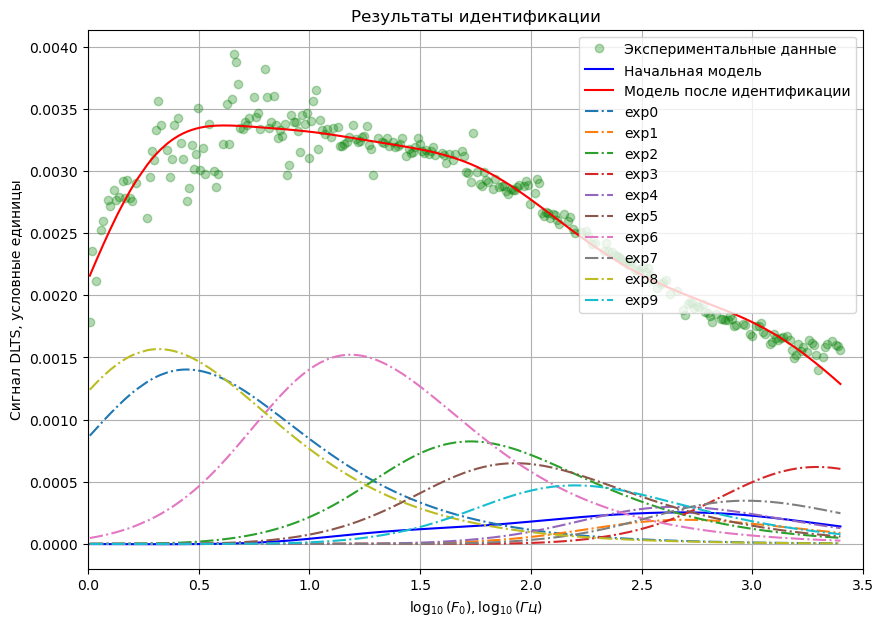

In [116]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multi_exp_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации

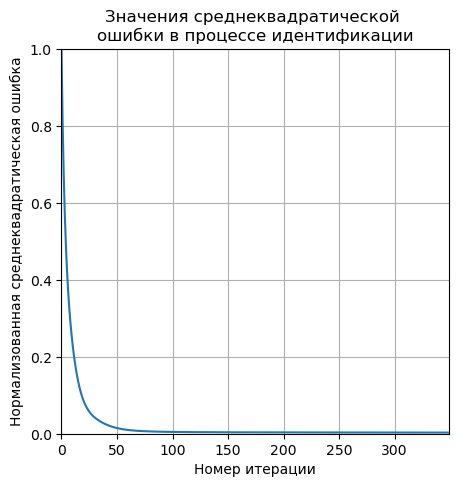

In [117]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multi_exp_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных

In [118]:
y_pred = multiexp_fs.predict(X_train)

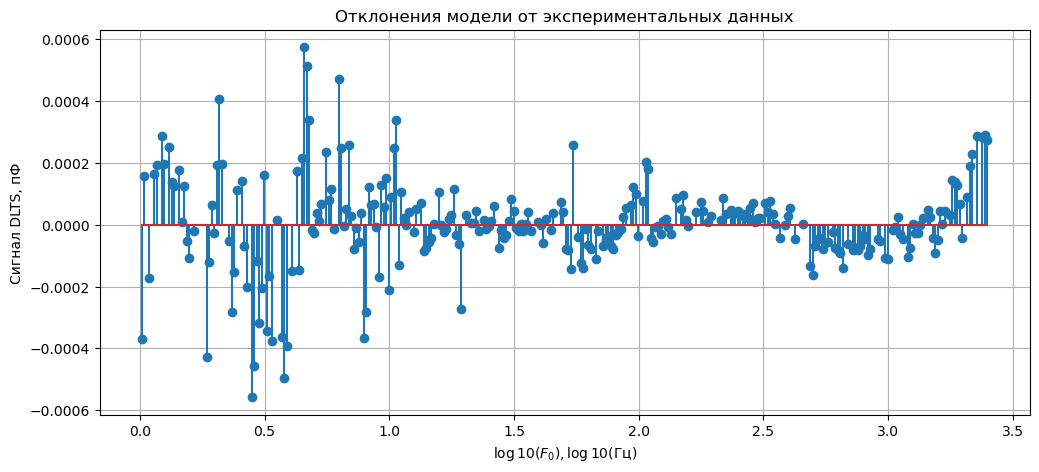

In [119]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, y_pred, ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multi_exp_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

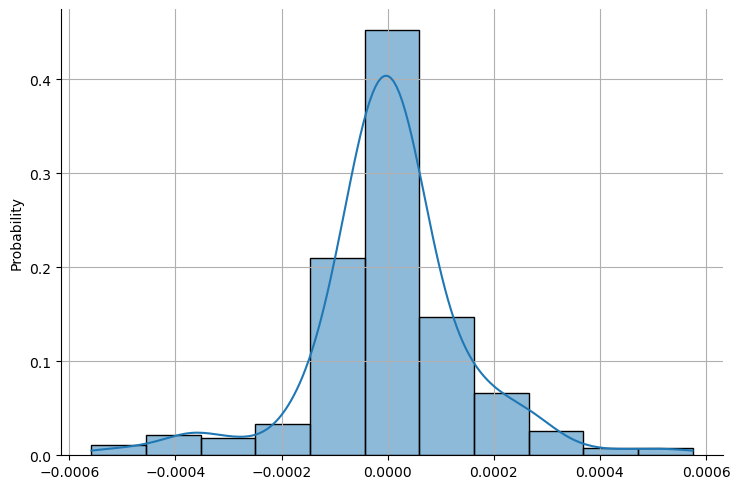

In [120]:
sns.displot(x=y_train - y_pred, bins=11, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multi_exp_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [121]:
# можно не делать, так как эта оценка есть в объекте grid_search

scores = cross_val_score(multiexp_fs, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-08 18:18:30.413390: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 18:18:30.413411: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 18:18:30.413415: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 18:18:30.413510: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 18:18:30.413523: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 18:18:30.413526: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 18:18:30.413628: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.0001304  0.00015056 0.00016758 0.00014874 0.00016195]
Mean: 0.0001518478778775252
Standard deviation: 1.281106010250754e-05


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [122]:
mean_squared_error(y_train, y_pred, squared=False)

0.0001460726637577237

Оценим ту же метрику на тестовых данных

In [123]:
mean_squared_error(y_test, multiexp_fs.predict(X_test), squared=False)

0.0001801128197818219

Выведем на экран полученный спектр

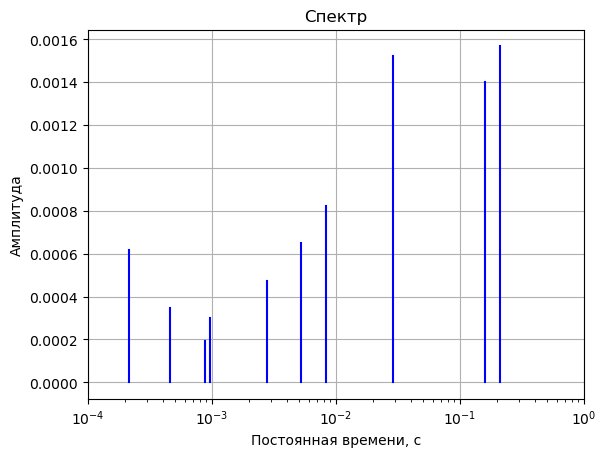

In [124]:
plot_spectr(multiexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_multi_exp_spectr.pdf',
            bbox_inches='tight')
plt.show()

## 4. 1564ЛЕ1№1\_п1\_2500Гц-1Гц\_10пФ\_+30С\_-4В-5В\_50мВ\_10мкс\_шаг\_0,1.csv
### 4.1. Подготовка экспериментальных данных

Чтение данных

In [17]:
print(data_frames[2][0])

1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1.csv


In [18]:
def get_X_y(dataset):
    filling_pulse = dataset.f_pulse[0] * 10 ** -6
    
    dataset = dataset.sample(frac=1, random_state=42)
    
    X_train = np.log10(dataset.frequency_hz.to_numpy())
    y_train = dataset.dlts_pf.to_numpy()
    
    return filling_pulse, X_train, y_train


filling_pulse, X_train, y_train = get_X_y(data_frames[2][1])

Выведем тренировачный набор данных

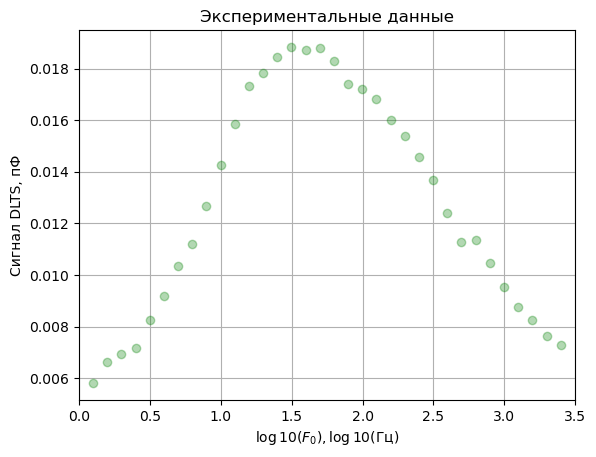

In [127]:
fig, ax = plot_experimental_points(X_train, y_train)
ax.set_xlim([0, 3.5])
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_train_data.pdf',
            bbox_inches='tight')
plt.show()

### 4.2. Идентификация моноэкспоненциальной модели с показателем $p$

In [128]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train)

SklSingleExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                          learning_rate=0.05, stop_val=1e-05)

Сохраняем модель

In [129]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_model.pkl'

# для сохранения модели
dump(monoexp_fs, f_name)

# для загрузки модели:
# monoexp_fs = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_model.pkl']

Вывод табличных результатов идентификации

In [130]:
fit_results_ = monoexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_fit_results.csv')
fit_results_.tail(10)

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
165,0.018481,0.00001,True,0.05,4.390693e-07,1,1000,0.274541,0.00001,-1.920520,False
166,0.018486,0.00001,True,0.05,4.386069e-07,1,1000,0.274687,0.00001,-1.920493,False
167,0.018491,0.00001,True,0.05,4.381700e-07,1,1000,0.274828,0.00001,-1.920467,False
168,0.018495,0.00001,True,0.05,4.377571e-07,1,1000,0.274965,0.00001,-1.920442,False
169,0.018500,0.00001,True,0.05,4.373669e-07,1,1000,0.275099,0.00001,-1.920417,False
170,0.018504,0.00001,True,0.05,4.369982e-07,1,1000,0.275229,0.00001,-1.920393,False
171,0.018508,0.00001,True,0.05,4.366497e-07,1,1000,0.275355,0.00001,-1.920370,False
172,0.018512,0.00001,True,0.05,4.363204e-07,1,1000,0.275478,0.00001,-1.920347,False
173,0.018516,0.00001,True,0.05,4.360091e-07,1,1000,0.275597,0.00001,-1.920325,False
174,0.018520,0.00001,True,0.05,4.357150e-07,1,1000,0.275713,0.00001,-1.920304,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

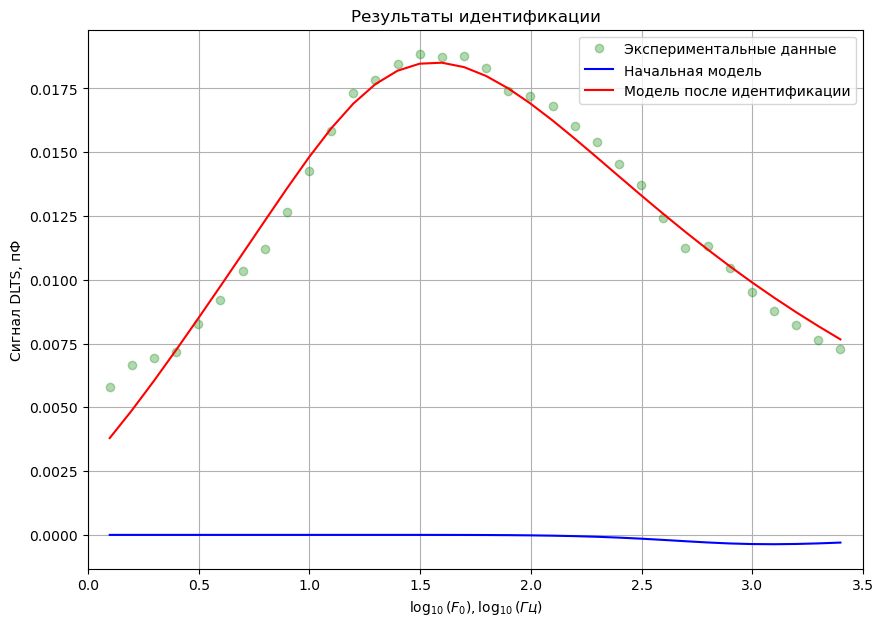

In [131]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, fit_results_, plot_exps=False)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации

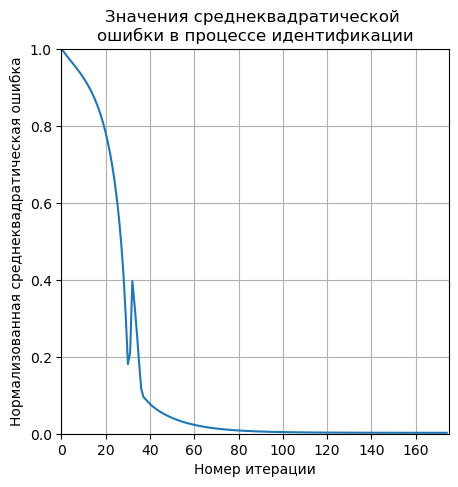

In [132]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_model_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных

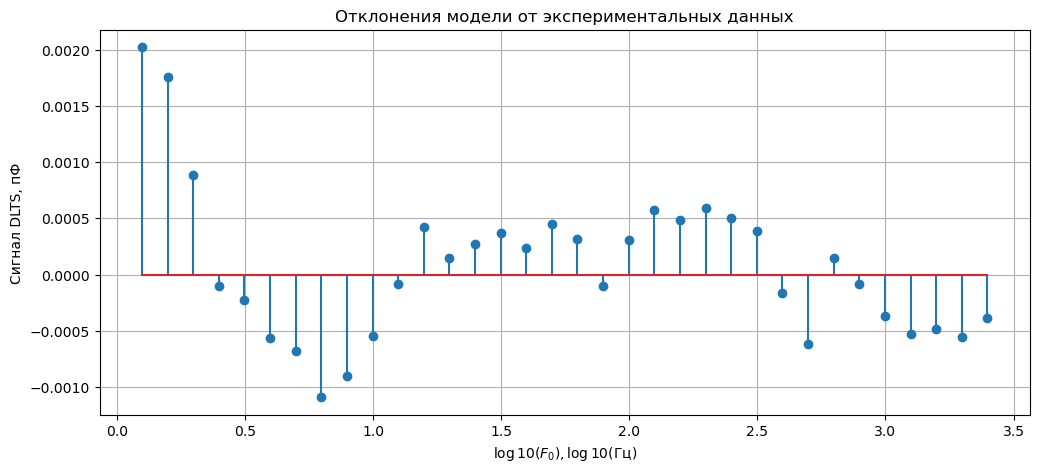

In [133]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, monoexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

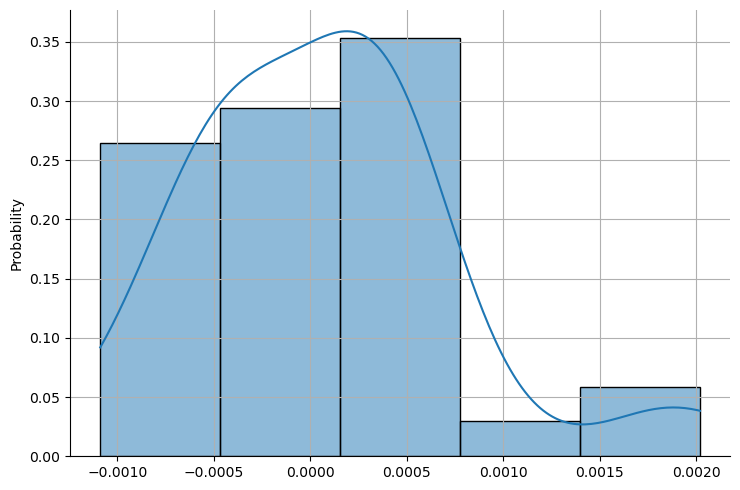

In [134]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=5, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [135]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train,
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

Scores - корни из среднеквадратических ошибок
Scores: [0.00071322 0.00080724 0.00055183 0.00052733 0.00096506]
Mean: 0.000712935805907767
Standard deviation: 0.00016301322095777933


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [136]:
mean_squared_error(y_train, monoexp_fs.predict(X_train), squared=False)

0.0006600871195619743

Выведем на экран полученный спектр

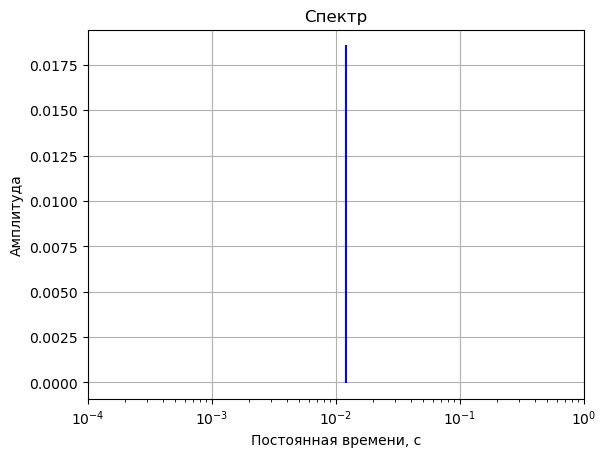

In [137]:
plot_spectr(monoexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01_single_exp_spectr.pdf',
            bbox_inches='tight')
plt.show()

### 4.3. Идентификация моноэкспоненциальной моделью с показателем $p=1$

Идентификация модели:

In [138]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False,
                                       fit_p_coef = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train)

SklSingleExpFrequencyScan(filling_pulse=9.999999999999999e-06, fit_p_coef=False,
                          learning_rate=0.05, stop_val=1e-05)

Сохраним модель

In [139]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal.pkl'

# для сохранения модели
dump(monoexp_fs, f_name)

# для загрузки модели:
# monoexp_fs = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal.pkl']

Вывод табличных результатов идентификации

In [140]:
fit_results_ = monoexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal_fit_results.csv')
monoexp_fs.fit_results_.tail(10)

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
192,0.023798,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931466,False
193,0.023803,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931467,False
194,0.023807,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931468,False
195,0.023812,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931469,False
196,0.023816,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931469,False
197,0.023821,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931470,False
198,0.023825,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931471,False
199,0.023829,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931472,False
200,0.023833,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931473,False
201,0.023837,0.00001,False,0.05,0.00003,1,1000,1.0,0.00001,-1.931473,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

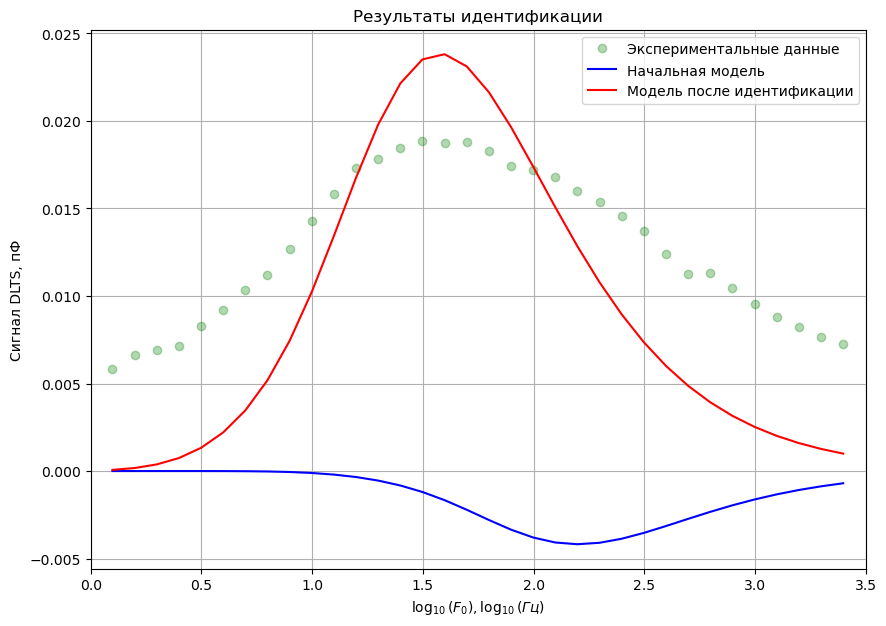

In [141]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, fit_results_, plot_exps=False)
ax.set_ylabel('Сигнал DLTS, пФ')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации

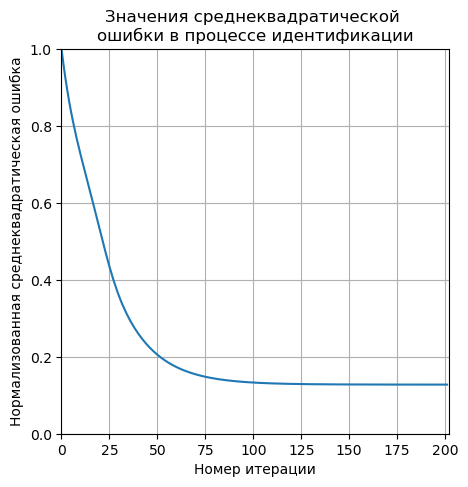

In [142]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal_model_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных

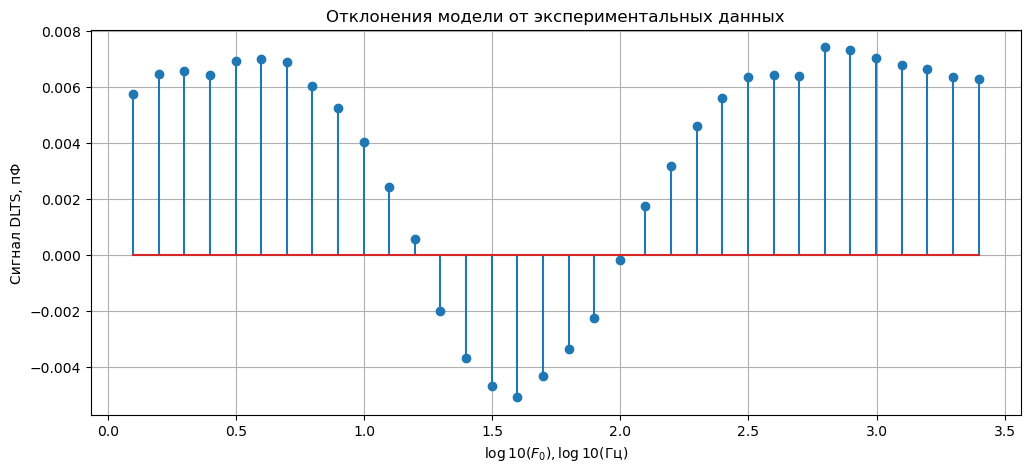

In [143]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, monoexp_fs.predict(X_train), ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

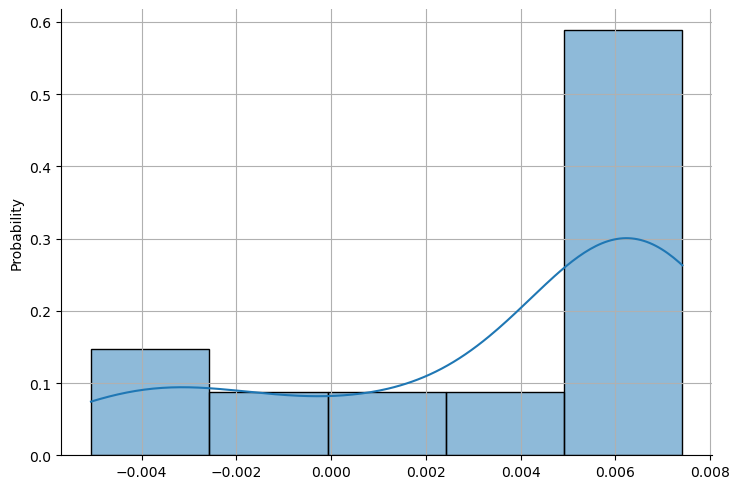

In [144]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=5, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [145]:
scores = cross_val_score(monoexp_fs, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-08 18:30:36.490852: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 18:30:36.490873: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 18:30:36.490878: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 18:30:36.490988: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 18:30:36.491008: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 18:30:36.491013: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 18:30:36.491142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.0055062  0.00555719 0.00642166 0.00622859 0.00547312]
Mean: 0.00583735039400498
Standard deviation: 0.0004038076278137835


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [146]:
mean_squared_error(y_train, monoexp_fs.predict(X_train), squared=False)

0.005436482153376011

Выведем на экран полученный спектр

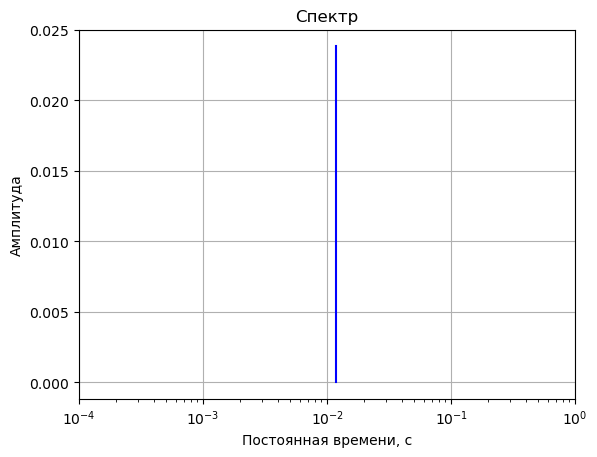

In [147]:
plot_spectr(monoexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_single_exp_ideal_spectr.pdf',
            bbox_inches='tight')
plt.show()

### 4.4. Идентификация мультиэкспоненциальной модели с n_exps>1

Идентификация мультиэкспоненциальной модели

In [19]:
multiexp_fs = SklMultiExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5
                                      )

In [20]:
param_grid = {'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(multiexp_fs, param_grid, cv=5, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=23)

In [21]:
grid_search.fit(X_train, y_train)

2022-10-08 19:28:19.944795: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 19:28:19.944835: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 19:28:19.944843: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 19:28:19.945084: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 19:28:19.945106: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 19:28:19.945112: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 19:28:19.945343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

2022-10-08 19:28:20.559746: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 19:28:20.559976: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 19:28:20.559989: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 19:28:20.560192: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 19:28:20.560225: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 19:28:20.560232: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 19:28:20.560428: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

2022-10-08 20:05:44.003073: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 20:05:44.003112: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 20:05:44.003120: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 20:05:44.003278: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 20:05:44.003302: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 20:05:44.003309: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 20:05:44.003527: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

GridSearchCV(cv=5,
             estimator=SklMultiExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                                                learning_rate=0.05,
                                                stop_val=1e-05),
             n_jobs=23, param_grid={'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True, scoring='neg_mean_squared_error')

Лучший результат показала модель со следующим количеством экспоненциальных составляющих (n_exps)

In [22]:
grid_search.best_params_

{'n_exps': 10}

Сохраним объект GridSearchCV

In [23]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multiexp_grid_search.pkl'

# для сохранения модели
dump(grid_search, f_name)

# для загрузки модели:
# grid_search = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multiexp_grid_search.pkl']

Ниже приведены результаты, которые показали модули с другими занчениями параметра (n_exps)

In [24]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.005851443429345993 {'n_exps': 1}
0.0027599562355025975 {'n_exps': 2}
0.001171469782978831 {'n_exps': 3}
0.0006324597462791823 {'n_exps': 4}
0.0005410213383238184 {'n_exps': 5}
0.00044458730531935837 {'n_exps': 6}
0.00045350425706288164 {'n_exps': 7}
0.0004281746259540669 {'n_exps': 8}
0.0004206515454048662 {'n_exps': 9}
0.0004055041292412233 {'n_exps': 10}


Сохраним лучшую модель

In [25]:
f_name = MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multiexp_best_estimator_.pkl'

# для сохранения модели
dump(grid_search.best_estimator_, f_name)

# для загрузки модели:
# best_estimator_ = load(f_name)

['../models/1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multiexp_best_estimator_.pkl']

Для лучшей модели выведем табличные результаты и графики.

Вывод табличных результатов идентификации

In [26]:
multiexp_fs = grid_search.best_estimator_
fit_results_ = multiexp_fs.fit_results_.copy()
fit_results_.to_csv(MODELS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_fit_results_1.csv')
multiexp_fs.fit_results_.tail(10)

,amplitude_0,amplitude_1,amplitude_2,amplitude_3,amplitude_4,amplitude_5,amplitude_6,amplitude_7,amplitude_8,amplitude_9,...,time_constant_pow_1,time_constant_pow_2,time_constant_pow_3,time_constant_pow_4,time_constant_pow_5,time_constant_pow_6,time_constant_pow_7,time_constant_pow_8,time_constant_pow_9,verbose
398,0.001878,0.003620,0.002564,0.002742,0.004886,0.005749,0.003005,0.004466,0.004533,0.002817,...,-2.280626,-3.278142,-3.487532,-1.550758,-0.646463,-2.375727,-1.804148,-1.624904,-2.454472,False
399,0.001878,0.003620,0.002564,0.002742,0.004886,0.005749,0.003005,0.004466,0.004534,0.002817,...,-2.280742,-3.278255,-3.488092,-1.550829,-0.646363,-2.375899,-1.804029,-1.624925,-2.454658,False
400,0.001878,0.003620,0.002563,0.002742,0.004887,0.005750,0.003005,0.004467,0.004534,0.002818,...,-2.280858,-3.278368,-3.488651,-1.550900,-0.646264,-2.376070,-1.803910,-1.624946,-2.454844,False
401,0.001878,0.003620,0.002562,0.002743,0.004887,0.005750,0.003005,0.004467,0.004534,0.002818,...,-2.280974,-3.278480,-3.489210,-1.550972,-0.646165,-2.376241,-1.803790,-1.624967,-2.455029,False
402,0.001878,0.003620,0.002562,0.002743,0.004888,0.005750,0.003005,0.004467,0.004535,0.002818,...,-2.281089,-3.278592,-3.489767,-1.551043,-0.646066,-2.376412,-1.803671,-1.624989,-2.455215,False
403,0.001878,0.003621,0.002561,0.002743,0.004888,0.005750,0.003006,0.004468,0.004535,0.002819,...,-2.281203,-3.278702,-3.490324,-1.551115,-0.645968,-2.376582,-1.803552,-1.625010,-2.455401,False
404,0.001878,0.003621,0.002561,0.002743,0.004888,0.005750,0.003006,0.004468,0.004536,0.002819,...,-2.281317,-3.278812,-3.490879,-1.551186,-0.645871,-2.376753,-1.803434,-1.625032,-2.455587,False
405,0.001878,0.003621,0.002560,0.002744,0.004889,0.005750,0.003006,0.004468,0.004536,0.002819,...,-2.281431,-3.278921,-3.491434,-1.551258,-0.645773,-2.376923,-1.803315,-1.625053,-2.455772,False
406,0.001878,0.003621,0.002560,0.002744,0.004889,0.005750,0.003006,0.004469,0.004536,0.002820,...,-2.281543,-3.279030,-3.491987,-1.551329,-0.645677,-2.377093,-1.803196,-1.625075,-2.455958,False
407,0.001878,0.003621,0.002559,0.002744,0.004889,0.005751,0.003006,0.004469,0.004537,0.002820,...,-2.281656,-3.279137,-3.492540,-1.551401,-0.645580,-2.377262,-1.803078,-1.625097,-2.456144,False


Вывод графика с экспериментальными данными и данными полученными на идентифицированной модели

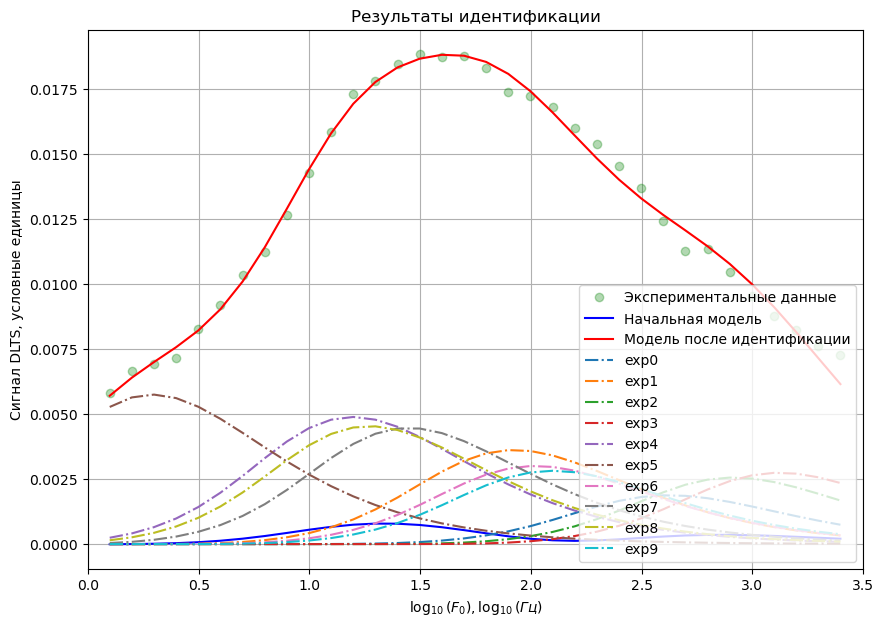

In [35]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, fit_results_)
plt.legend(loc='lower right')
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_model.pdf',
            bbox_inches='tight')
plt.show()

Вывод графика значений среднеквадратической ошибки в процессе идентификации

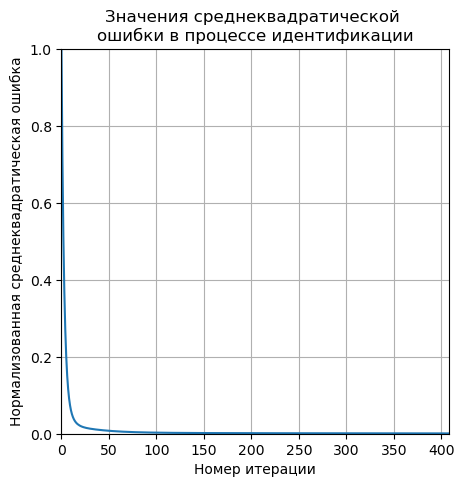

In [28]:
plot_loss_path(fit_results_)
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_loss.pdf',
            bbox_inches='tight')
plt.show()

Выведем график отклонений результатов, полученных на модели, от экспериментальных данных

In [29]:
y_pred = multiexp_fs.predict(X_train)

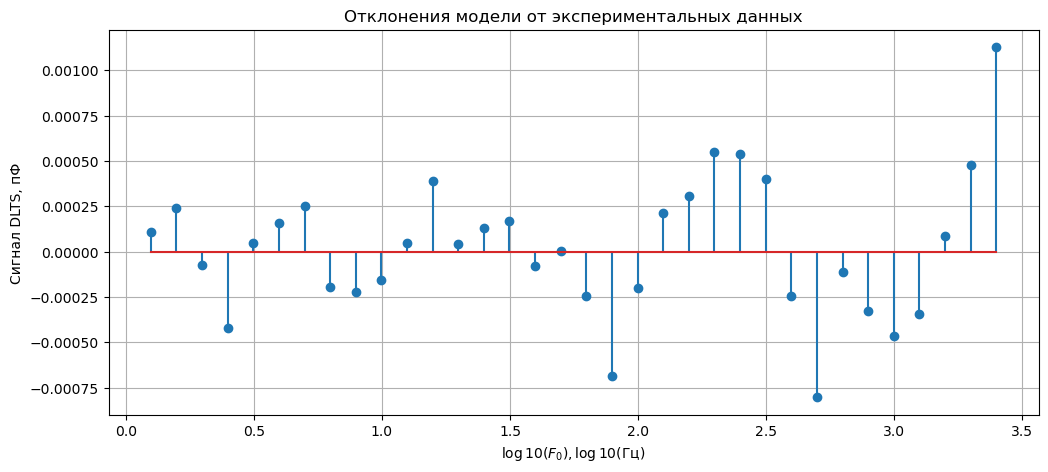

In [30]:
fig, ax = plt.subplots(figsize=(12, 5))

ax = plot_deviations(X_train, y_train, y_pred, ax=ax)

ax.set_ylabel('Сигнал DLTS, пФ')

plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_deviations.pdf',
            bbox_inches='tight')
plt.show()

Построим гистограмму отклонений данных, полученных на идентифицированной модели, от экспериментальных данных

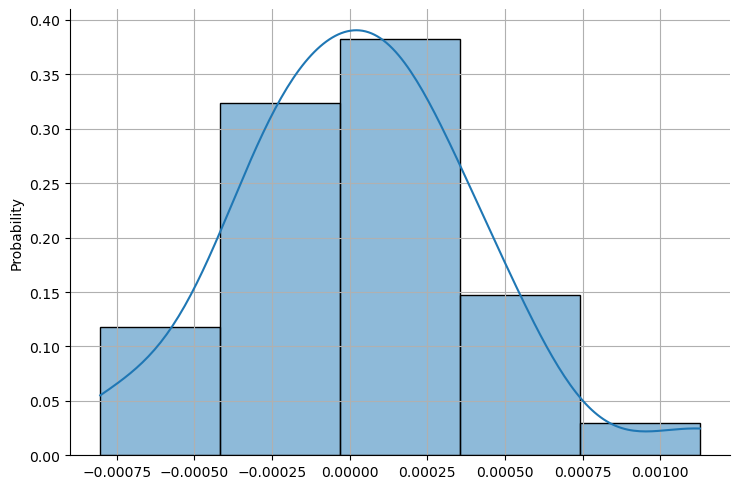

In [31]:
sns.displot(x=y_train - y_pred, bins=5, kde=True, stat='probability', aspect=1.5)
plt.grid()
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_hist.pdf',
            bbox_inches='tight')
plt.show()

Оценим модель при помощи кросс-валидации

In [32]:
# можно не делать, так как эта оценка есть в объекте grid_search

scores = cross_val_score(multiexp_fs, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=5, 
                         n_jobs=23)

display_scores(scores)

2022-10-08 20:14:28.981268: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-08 20:14:28.981292: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-10-08 20:14:28.981297: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-10-08 20:14:28.981397: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-10-08 20:14:28.981410: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-08 20:14:28.981414: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-10-08 20:14:28.981524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

Scores - корни из среднеквадратических ошибок
Scores: [0.00029307 0.00058792 0.00034894 0.00045789 0.00043439]
Mean: 0.000424443227125945
Standard deviation: 0.00010089624007473877


Оценим корень из среднеквадратической ошибки между экспериментальными данными и данными, полученными на идентифицированной модели на тренировачных данных

In [33]:
mean_squared_error(y_train, y_pred, squared=False)

0.0003753467836255466

Выведем на экран полученный спектр

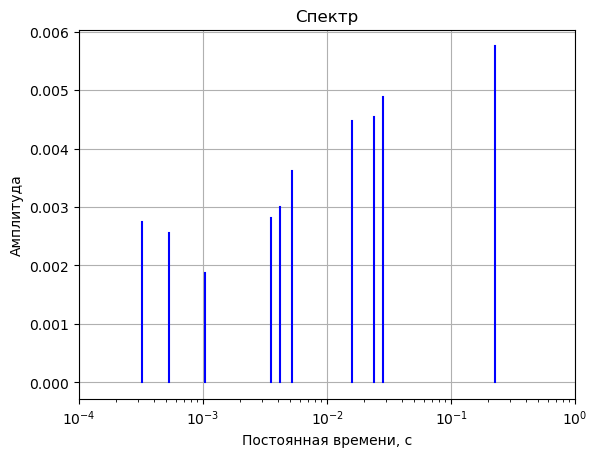

In [34]:
plot_spectr(multiexp_fs.exps_params_, xlim=[1/10000, 1])
plt.savefig(PLOTS_PATH + '1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1_multi_exp_spectr.pdf',
            bbox_inches='tight')
plt.show()